#2022 Computational Intelligence Project

## Topic of the project: Image classification of Stanford Dogs

## Author: Szymon Lepianka

Main goal of the project is to construct a neural network model that would be able to classify breeds of dogs based on their images. It will be done by training few models and choosing best one. Dataset used comes from kaggle.com:

[Kaggle](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset)

and contains over 20,000 images of 120 dog breeds.


## Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input, ZeroPadding2D,GlobalAveragePooling2D,MaxPool2D
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
import os

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

TensorFlow version: 2.8.0
Keras version: 2.8.0


## Kaggle setup

In [ ]:
import json
!pip install kaggle
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json

api_token = {"username":"szymonlepianka","key":"486fdb332439db4439ff19ecc397b6ea"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/stanford-dogs-dataset
! mkdir input
! 7z x stanford-dogs-dataset.zip -oinput -aoa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
stanford-dogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘input’: File exists

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 786955428 bytes (751 MiB)

Extracting archive: stanford-dogs-dataset.zip
  9% 4096 Open              --
Path = stanford-dogs-dataset.zip
Type = zip
Physical Size = 786955428

  0%      0% 726 - annotations/Annotation/n02086079-Pekinese/n02086079_8726                                                    

### Cropping, discarding too small images and saving do gdrive
The files in the Annotation folder are XML-structured. It contains the necessary information, a breed name and a bounding box. In some images, the dog does not always occupy the entire area. Therefore, these images will have to be cropped.

In [ ]:
from tqdm import tqdm
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image

imgsize = 200
minimum_size = 60
counter_of_discarded_images = 0
images_path = './input/images/Images/'
cropped_images_path = './input2/images2/Images2/'
annotations_path = './input/annotations/Annotation/'
breeds = os.listdir(images_path)

breedname_to_number = {}
number_to_breedname = {}
for i in range(len(breeds)):
    breedname_to_number.update({breeds[i]: i})
    number_to_breedname.update({i : breeds[i]})


def training_data(label,data_dir):
    cnt = 0
    # X = []
    # Z = []

    for image_filename in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,image_filename)

        img = Image.open(images_path+label+'/'+image_filename)

        # img = tf.io.read_file(path)
        # img = tf.image.decode_jpeg(img, channels=3)

        # img = cv2.imread(images_path+label+'/'+image_filename, cv2.IMREAD_GRAYSCALE)

        # parsing XML for bounding box:
        adnotation_filename = image_filename[:len(image_filename) - 4]
        tree = ET.parse(annotations_path + label + '/' + adnotation_filename)
        root = tree.getroot()
        objects = root.findall('object') # There can be more than one dog in one image
        found_enough_big_bb = False
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            if xmax - xmin >= minimum_size and ymax - ymin >= minimum_size:
                
                img = img.crop((xmin, ymin, xmax, ymax))
                img = img.convert('RGB')
                img = img.resize((imgsize, imgsize))

                img.save(cropped_images_path + label + '/' + image_filename)

                # img.save(dir_to_save_images + 'data/' + label + '/' + image_filename)
                # tree.write(dir_to_save_images + 'xml/' + label + '/' + adnotation_filename)

                # height = img.shape[0]
                # width = img.shape[1]
                # h_target = ymax-ymin if ymax < height else height-ymin
                # w_target = xmax-xmin if xmax < width else width-xmin
                # img = tf.image.crop_to_bounding_box(img, ymin, xmin, h_target, w_target)
                # img = tf.image.resize(img, [imgsize, imgsize])
                # img /= 255.0

                # img = img[ymin:ymax, xmin:xmax]
                # img = cv2.resize(img, (imgsize, imgsize))
                # img = np.array(img)
                # img = img/255

                # norm = np.zeros((img.shape[0],img.shape[1]))
                # img = cv2.normalize(img,norm,0,1,cv2.NORM_MINMAX)
                # cv2.imshow("Low Quality Image",img)
                # cv2.imshow("Normalized Image",norm_image)

                # X.append(img)
                # Z.append(str(label))

                # output.append([img, breedname_to_number[label]])

                found_enough_big_bb = True
                break
        if not found_enough_big_bb:
            cnt += 1
    # return X, Z, cnt

# print(os.listdir())

# all_image = []
# all_label = []

# os.mkdir(dir_to_save_images + 'data')
# os.mkdir(dir_to_save_images + 'xml')

os.mkdir("./input2/")
os.mkdir("./input2/images2/")
os.mkdir("./input2/images2/Images2/")

for label in breeds:
    os.mkdir("./input2/images2/Images2/" + label + "/")
    training_data(label, images_path + label)

100%|██████████| 159/159 [00:00<00:00, 385.86it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


### 9 random photos, with bounding boxes marked

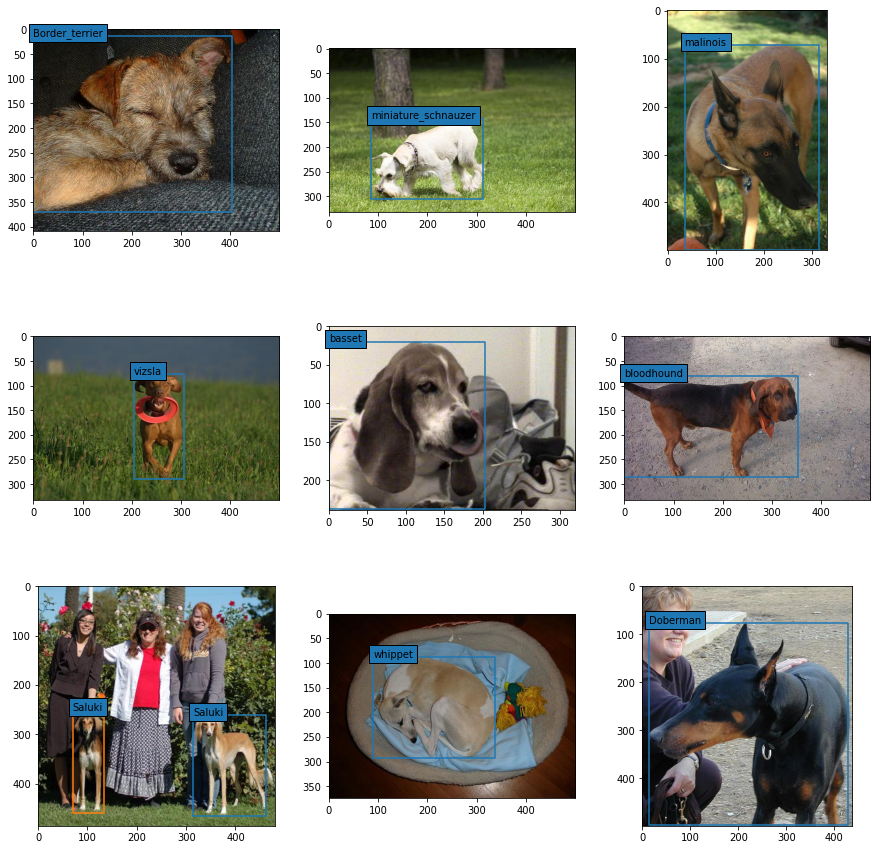

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    breed = np.random.choice(os.listdir(annotations_path))
    dog = np.random.choice(os.listdir(annotations_path + breed))
    img = Image.open(images_path + breed + '/' + dog + '.jpg') 

    # parsing XML for bounding box:
    tree = ET.parse(annotations_path + breed + '/' + dog)
    root = tree.getroot()
    objects = root.findall('object') # There can be more than one dog in one image
    plt.imshow(img)
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None})

### 12 example cropped photos

In [ ]:
breed_list = os.listdir(cropped_images_path)
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = cropped_images_path + "{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

n02102040-English_springer


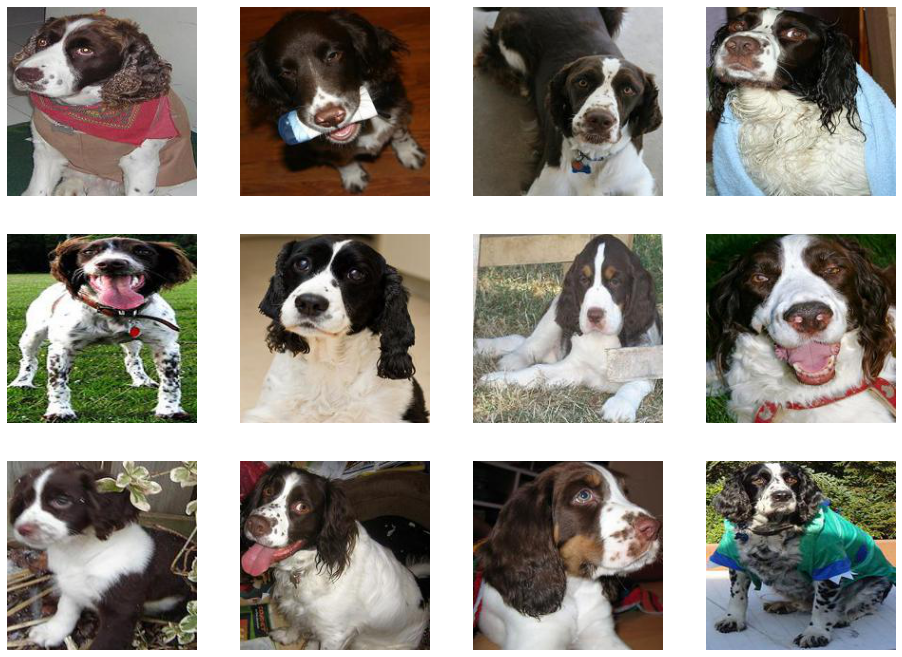

In [ ]:
print(breed_list[0])
show_dir_images(breed_list[0], 12)

### Control of the number of classes

In [ ]:
len(pd.Series(np_labels).unique())

120

## Data overview

### Number of breeds

In [ ]:
# images_path = dir_to_save_images + 'data/'
images_path = './input/images/Images/'
breeds = os.listdir(images_path)
print(len(breeds))

120


### Number of images

In [ ]:
n = 0
for breed in breeds:
    n += len(os.listdir(images_path + breed))
print(n)

20580


### All breeds list

In [ ]:
breeds

['n02107312-miniature_pinscher',
 'n02105641-Old_English_sheepdog',
 'n02116738-African_hunting_dog',
 'n02108551-Tibetan_mastiff',
 'n02095570-Lakeland_terrier',
 'n02105056-groenendael',
 'n02085782-Japanese_spaniel',
 'n02101006-Gordon_setter',
 'n02098413-Lhasa',
 'n02091467-Norwegian_elkhound',
 'n02112018-Pomeranian',
 'n02096051-Airedale',
 'n02100735-English_setter',
 'n02104029-kuvasz',
 'n02089078-black-and-tan_coonhound',
 'n02112706-Brabancon_griffon',
 'n02096177-cairn',
 'n02109525-Saint_Bernard',
 'n02107574-Greater_Swiss_Mountain_dog',
 'n02106550-Rottweiler',
 'n02105855-Shetland_sheepdog',
 'n02105162-malinois',
 'n02090379-redbone',
 'n02093256-Staffordshire_bullterrier',
 'n02098105-soft-coated_wheaten_terrier',
 'n02100877-Irish_setter',
 'n02094258-Norwich_terrier',
 'n02091134-whippet',
 'n02102318-cocker_spaniel',
 'n02113712-miniature_poodle',
 'n02089973-English_foxhound',
 'n02107683-Bernese_mountain_dog',
 'n02095314-wire-haired_fox_terrier',
 'n02113186-Car

## Preparation of data

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 200
IMG_WIDTH = 200

In [ ]:
import pathlib

data_dir = pathlib.Path(cropped_images_path)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['n02102040-English_springer' 'n02107683-Bernese_mountain_dog'
 'n02088632-bluetick' 'n02110063-malamute' 'n02092002-Scottish_deerhound'
 'n02106550-Rottweiler' 'n02094433-Yorkshire_terrier' 'n02110958-pug'
 'n02112137-chow' 'n02107908-Appenzeller' 'n02111889-Samoyed'
 'n02096177-cairn' 'n02099429-curly-coated_retriever' 'n02111129-Leonberg'
 'n02085620-Chihuahua' 'n02095570-Lakeland_terrier'
 'n02097130-giant_schnauzer' 'n02108422-bull_mastiff'
 'n02095889-Sealyham_terrier' 'n02110627-affenpinscher'
 'n02109047-Great_Dane' 'n02088466-bloodhound' 'n02086240-Shih-Tzu'
 'n02107142-Doberman' 'n02097474-Tibetan_terrier'
 'n02101006-Gordon_setter' 'n02104029-kuvasz' 'n02096437-Dandie_Dinmont'
 'n02098105-soft-coated_wheaten_terrier' 'n02102973-Irish_water_spaniel'
 'n02105505-komondor' 'n02100236-German_short-haired_pointer'
 'n02097209-standard_schnauzer' 'n02105251-briard' 'n02105056-groenendael'
 'n02091244-Ibizan_hound' 'n02113624-toy_poodle' 'n02100583-vizsla'
 'n02086910-papillon' 'n0

### Train test split

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(cropped_images_path,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                              batch_size=BATCH_SIZE,
                                              classes = list(CLASS_NAMES),
                                              subset='training',
                                              class_mode='categorical',
                                              shuffle=True,
                                              interpolation = 'lanczos')
valid_generator = datagen.flow_from_directory(cropped_images_path,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                              batch_size=BATCH_SIZE,
                                              classes = list(CLASS_NAMES),
                                              subset='validation',
                                              class_mode='categorical',
                                              shuffle=True,
                                              interpolation = 'lanczos')
batchX, batchy = train_generator.next()
valid_generator.index_array = None
valid_generator.shuffle = False 
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 16469 images belonging to 120 classes.
Found 4057 images belonging to 120 classes.
Batch shape=(32, 200, 200, 3), min=0.000, max=1.000


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

20526

In [ ]:
nb_classes = len(train_generator.class_indices)
print(nb_classes)

120


## Model 1

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())
        
    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                        

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model10_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
514/515 [============================>.] - ETA: 0s - loss: 4.1351 - accuracy: 0.0771
Epoch 1: val_accuracy improved from -inf to 0.03229, saving model to model10_cnn.h5
515/515 [==============================] - 42s 59ms/step - loss: 4.1353 - accuracy: 0.0770 - val_loss: 4.8755 - val_accuracy: 0.0323
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 3.4850 - accuracy: 0.1632
Epoch 2: val_accuracy improved from 0.03229 to 0.15849, saving model to model10_cnn.h5
515/515 [==============================] - 30s 58ms/step - loss: 3.4850 - accuracy: 0.1632 - val_loss: 3.5528 - val_accuracy: 0.1585
Epoch 3/100
514/515 [============================>.] - ETA: 0s - loss: 2.9874 - accuracy: 0.2534
Epoch 3: val_accuracy did not improve from 0.15849
515/515 [==============================] - 29s 57ms/step - loss: 2.9876 - accuracy: 0.2535 - val_loss: 3.8455 - val_accuracy: 0.1057
Epoch 4/100
514/515 [============================>.] - ETA: 0s - loss: 2.5303 - accuracy

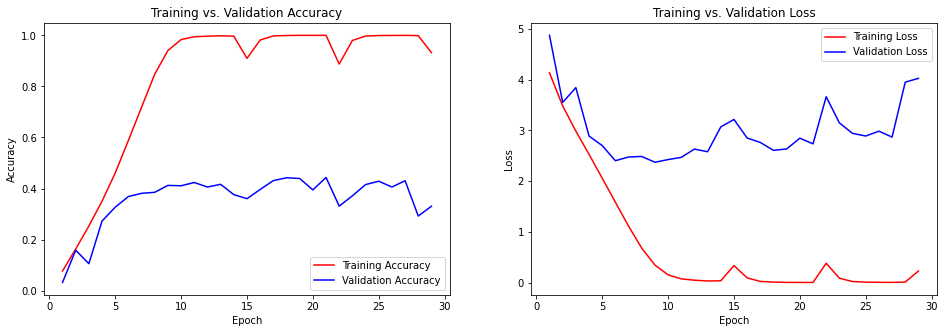

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 45ms/step - loss: 4.0276 - accuracy: 0.3308


Confusion Matrix


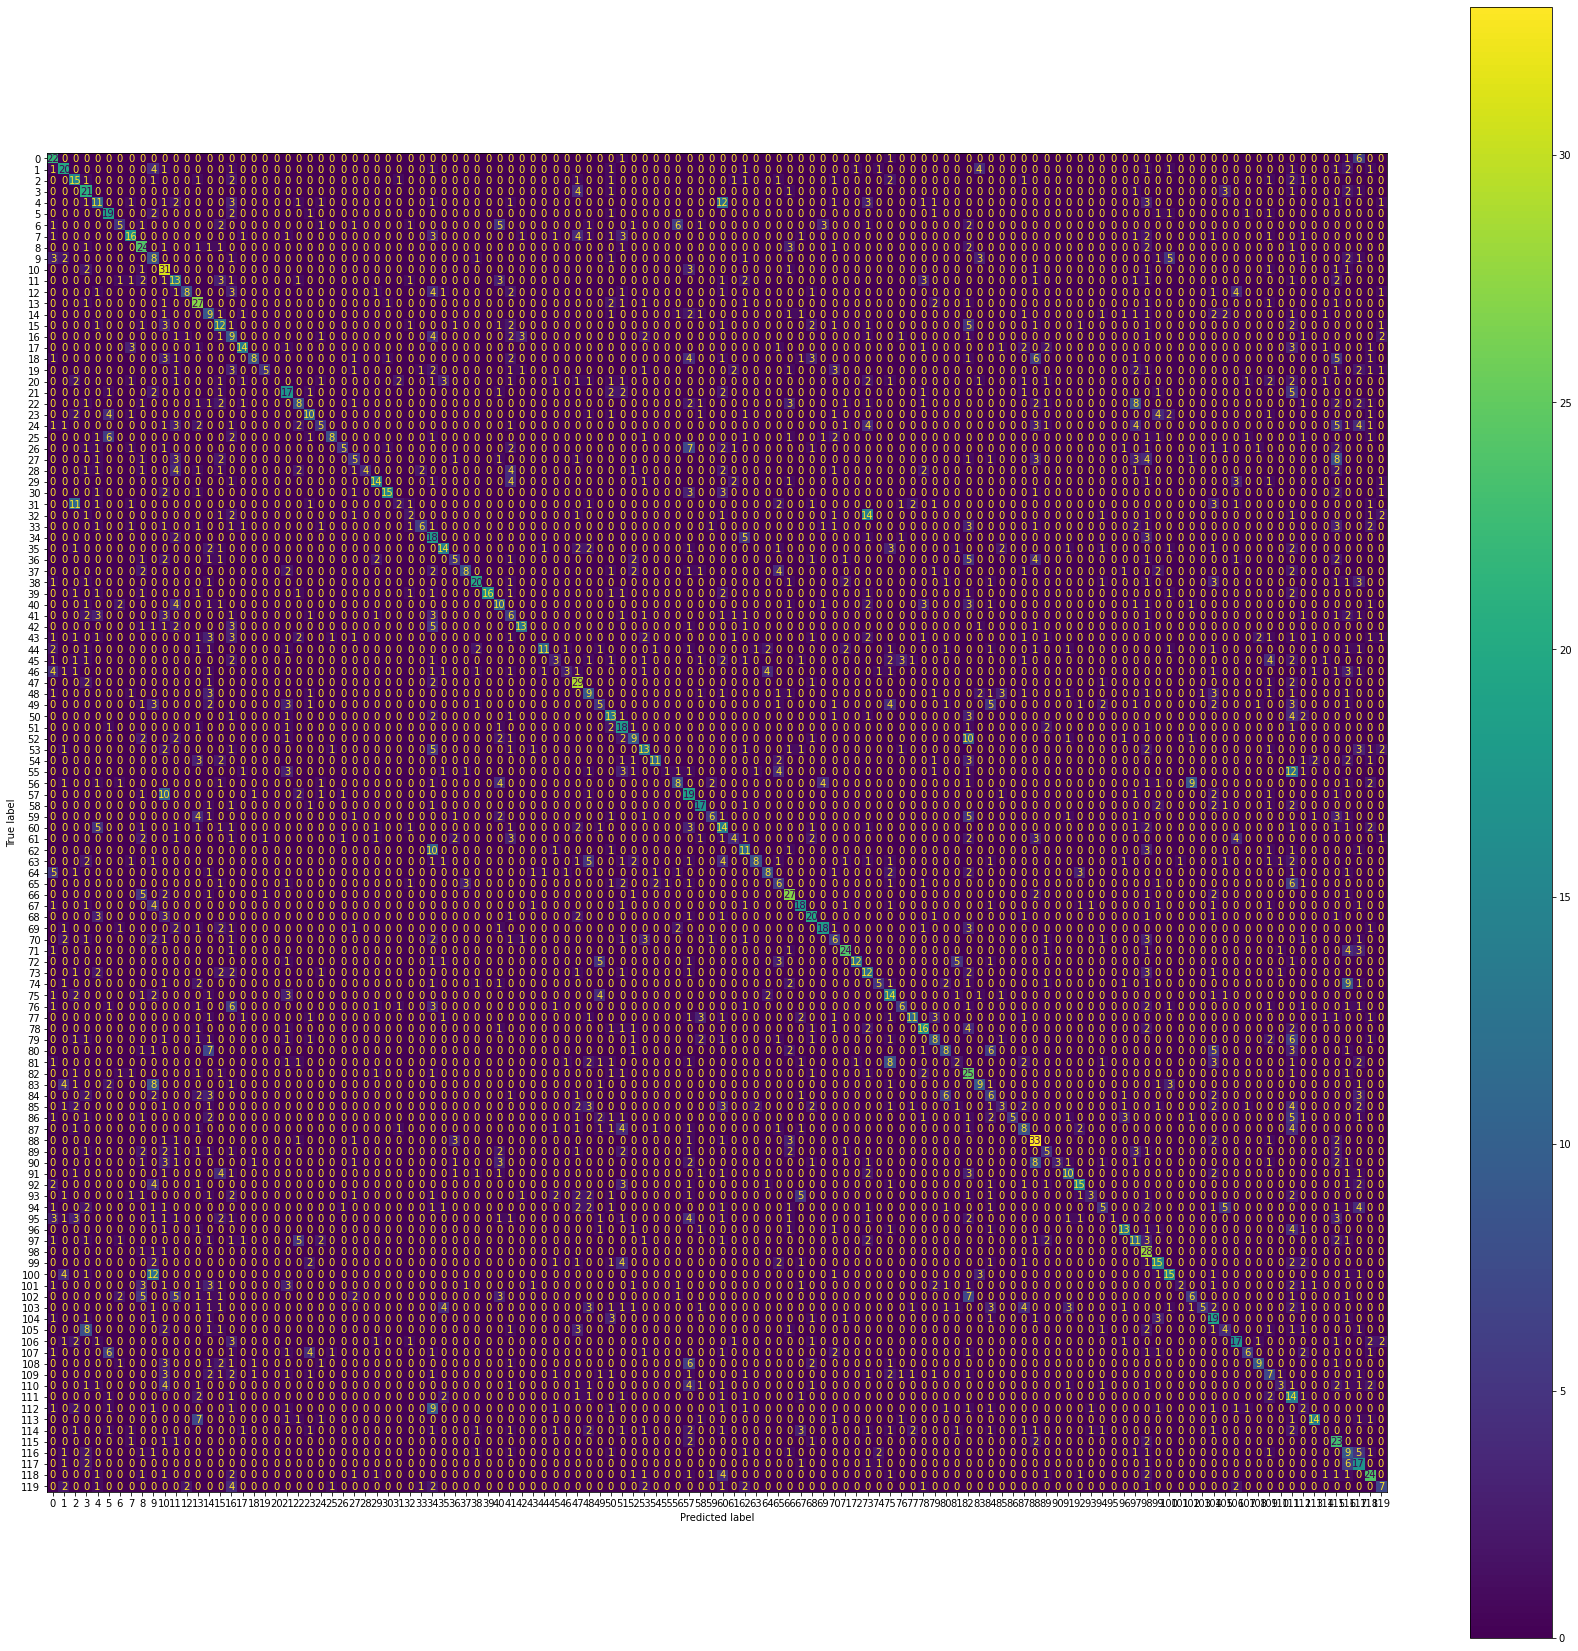

Classification Report
              precision    recall  f1-score   support

           0       0.35      0.71      0.47        31
           1       0.43      0.47      0.45        43
           2       0.28      0.44      0.34        34
           3       0.32      0.60      0.42        35
           4       0.28      0.24      0.26        46
           5       0.44      0.63      0.52        30
           6       0.33      0.16      0.21        32
           7       0.50      0.40      0.44        40
           8       0.36      0.62      0.45        39
           9       0.12      0.27      0.17        30
          10       0.31      0.72      0.43        43
          11       0.24      0.33      0.28        39
          12       0.73      0.27      0.39        30
          13       0.36      0.66      0.47        41
          14       0.15      0.30      0.20        30
          15       0.22      0.31      0.26        39
          16       0.11      0.29      0.16        31
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 2

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())
        
    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 99, 99, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                        

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model10_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.2571 - accuracy: 0.0612
Epoch 1: val_accuracy improved from -inf to 0.03328, saving model to model10_cnn.h5
515/515 [==============================] - 48s 70ms/step - loss: 4.2571 - accuracy: 0.0612 - val_loss: 4.7335 - val_accuracy: 0.0333
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 3.7150 - accuracy: 0.1271
Epoch 2: val_accuracy improved from 0.03328 to 0.11117, saving model to model10_cnn.h5
515/515 [==============================] - 34s 66ms/step - loss: 3.7150 - accuracy: 0.1271 - val_loss: 3.9527 - val_accuracy: 0.1112
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 3.2816 - accuracy: 0.1974
Epoch 3: val_accuracy improved from 0.11117 to 0.13902, saving model to model10_cnn.h5
515/515 [==============================] - 34s 66ms/step - loss: 3.2816 - accuracy: 0.1974 - val_loss: 3.8250 - val_accuracy: 0.1390
Epoch 4/100
515/515 [==============================]

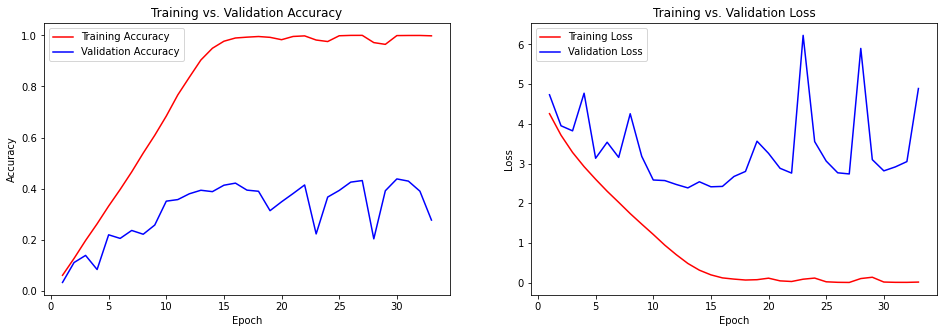

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 46ms/step - loss: 4.8912 - accuracy: 0.2773


Confusion Matrix


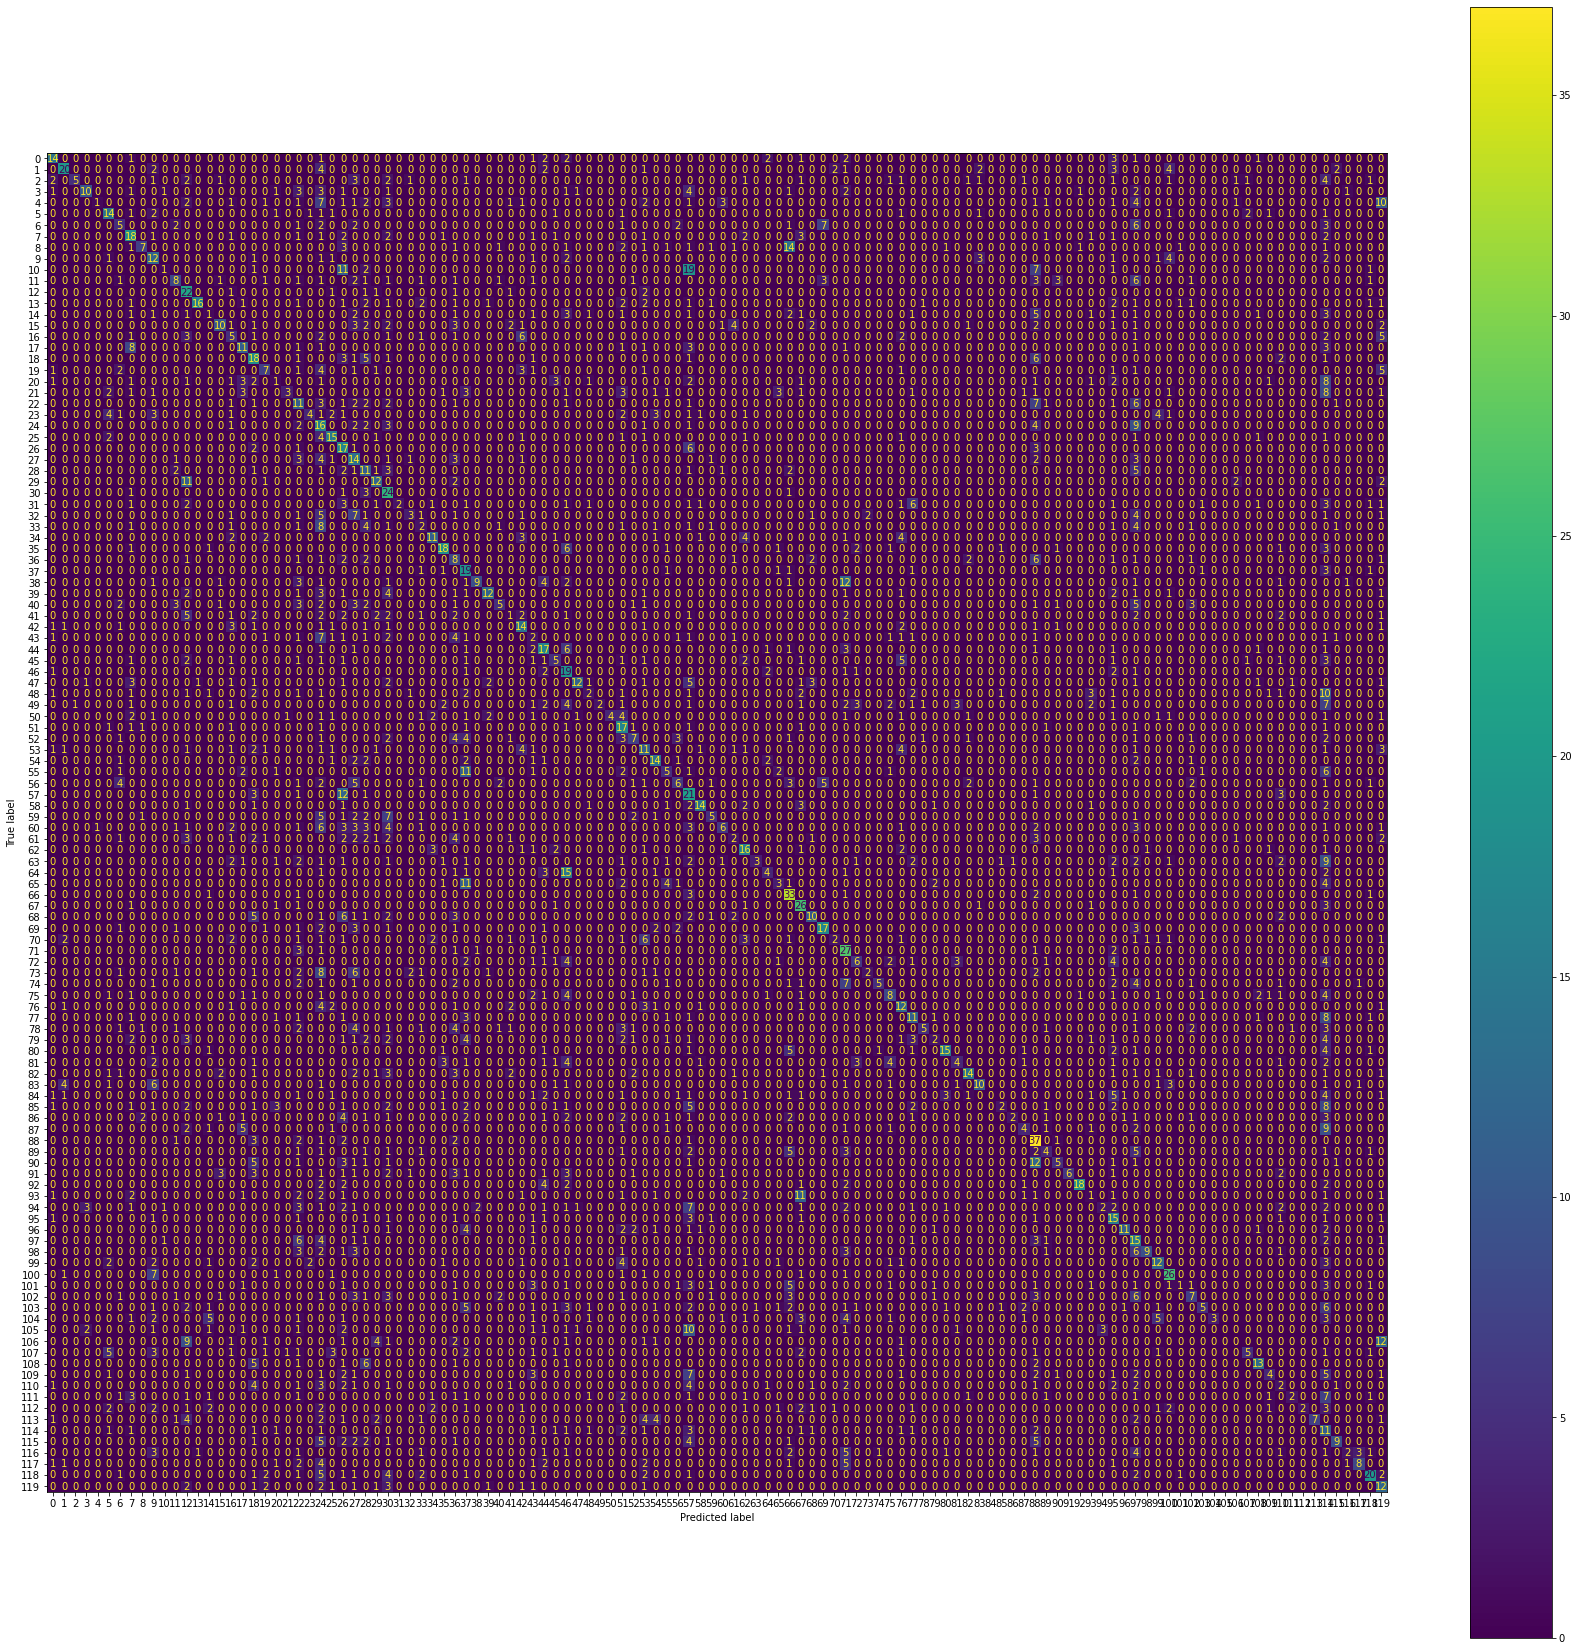

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        31
           1       0.62      0.47      0.53        43
           2       0.83      0.15      0.25        34
           3       0.62      0.29      0.39        35
           4       0.50      0.02      0.04        46
           5       0.37      0.47      0.41        30
           6       0.19      0.16      0.17        32
           7       0.29      0.45      0.35        40
           8       0.58      0.18      0.27        39
           9       0.21      0.40      0.27        30
          10       0.25      0.02      0.04        43
          11       0.35      0.21      0.26        39
          12       0.25      0.73      0.37        30
          13       0.89      0.39      0.54        41
          14       0.06      0.03      0.04        30
          15       0.48      0.26      0.33        39
          16       0.14      0.16      0.15        31
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 3

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
        
    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 99, 99, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                             
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model15_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.3229 - accuracy: 0.0519
Epoch 1: val_accuracy improved from -inf to 0.04683, saving model to model15_cnn.h5
515/515 [==============================] - 37s 69ms/step - loss: 4.3229 - accuracy: 0.0519 - val_loss: 4.7739 - val_accuracy: 0.0468
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 3.8253 - accuracy: 0.1038
Epoch 2: val_accuracy improved from 0.04683 to 0.05694, saving model to model15_cnn.h5
515/515 [==============================] - 37s 72ms/step - loss: 3.8253 - accuracy: 0.1038 - val_loss: 4.7246 - val_accuracy: 0.0569
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 3.3950 - accuracy: 0.1645
Epoch 3: val_accuracy improved from 0.05694 to 0.14888, saving model to model15_cnn.h5
515/515 [==============================] - 35s 67ms/step - loss: 3.3950 - accuracy: 0.1645 - val_loss: 3.6351 - val_accuracy: 0.1489
Epoch 4/100
515/515 [==============================]

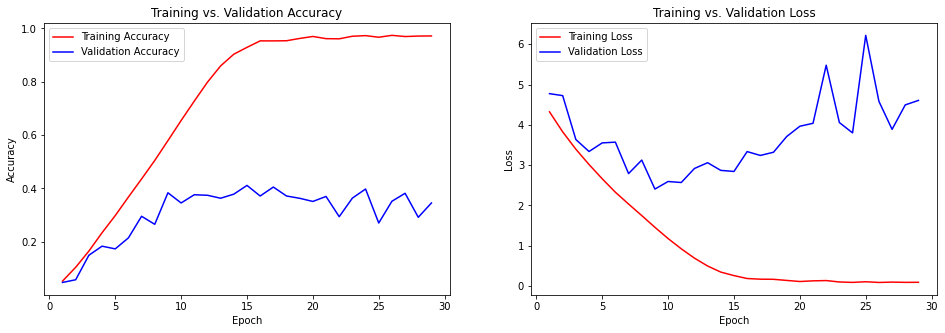

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 46ms/step - loss: 4.6057 - accuracy: 0.3451


Confusion Matrix


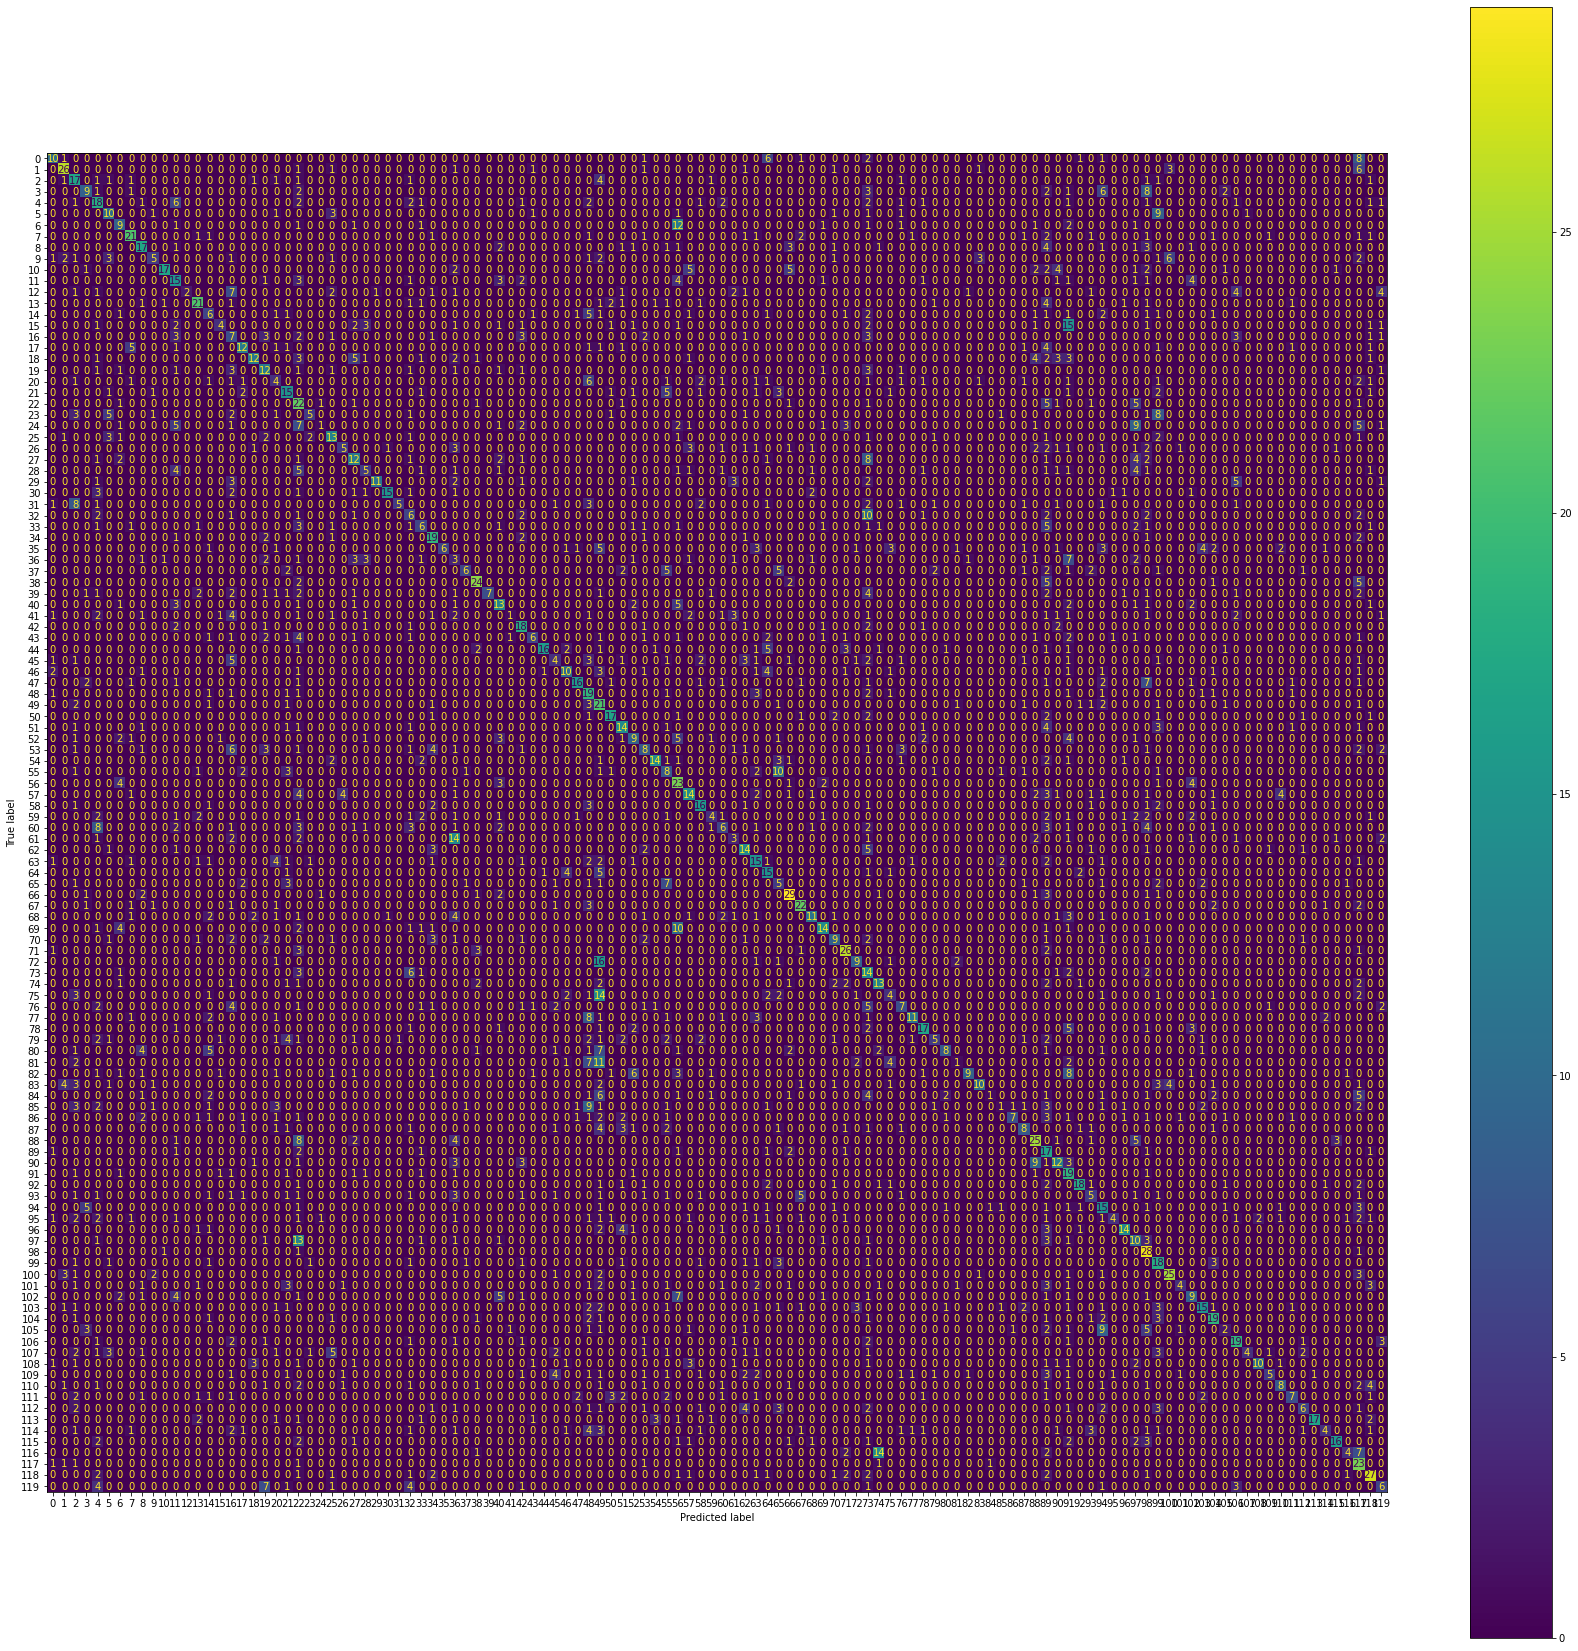

Classification Report
              precision    recall  f1-score   support

           0       0.43      0.32      0.37        31
           1       0.63      0.60      0.62        43
           2       0.24      0.50      0.32        34
           3       0.39      0.26      0.31        35
           4       0.26      0.39      0.31        46
           5       0.32      0.33      0.33        30
           6       0.27      0.28      0.28        32
           7       0.54      0.53      0.53        40
           8       0.45      0.44      0.44        39
           9       0.38      0.17      0.23        30
          10       0.85      0.40      0.54        43
          11       0.26      0.38      0.31        39
          12       1.00      0.07      0.12        30
          13       0.58      0.51      0.55        41
          14       0.18      0.20      0.19        30
          15       0.44      0.10      0.17        39
          16       0.10      0.23      0.14        31
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 4

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 99, 99, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 48, 48, 128)      0         
 g2D)                                                            
                                                      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model15_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.5609 - accuracy: 0.0353
Epoch 1: val_accuracy improved from -inf to 0.03352, saving model to model15_cnn.h5
515/515 [==============================] - 35s 67ms/step - loss: 4.5609 - accuracy: 0.0353 - val_loss: 4.7691 - val_accuracy: 0.0335
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 4.1293 - accuracy: 0.0681
Epoch 2: val_accuracy improved from 0.03352 to 0.05940, saving model to model15_cnn.h5
515/515 [==============================] - 34s 66ms/step - loss: 4.1293 - accuracy: 0.0681 - val_loss: 4.3730 - val_accuracy: 0.0594
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 3.8195 - accuracy: 0.1009
Epoch 3: val_accuracy improved from 0.05940 to 0.06926, saving model to model15_cnn.h5
515/515 [==============================] - 34s 66ms/step - loss: 3.8195 - accuracy: 0.1009 - val_loss: 4.3710 - val_accuracy: 0.0693
Epoch 4/100
515/515 [==============================]

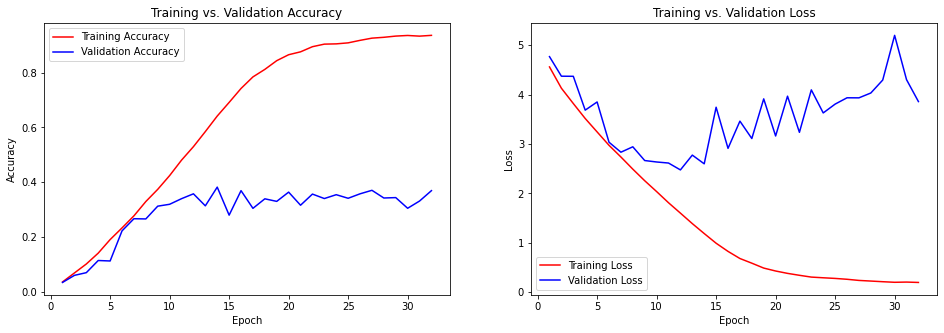

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 46ms/step - loss: 3.8589 - accuracy: 0.3687


Confusion Matrix


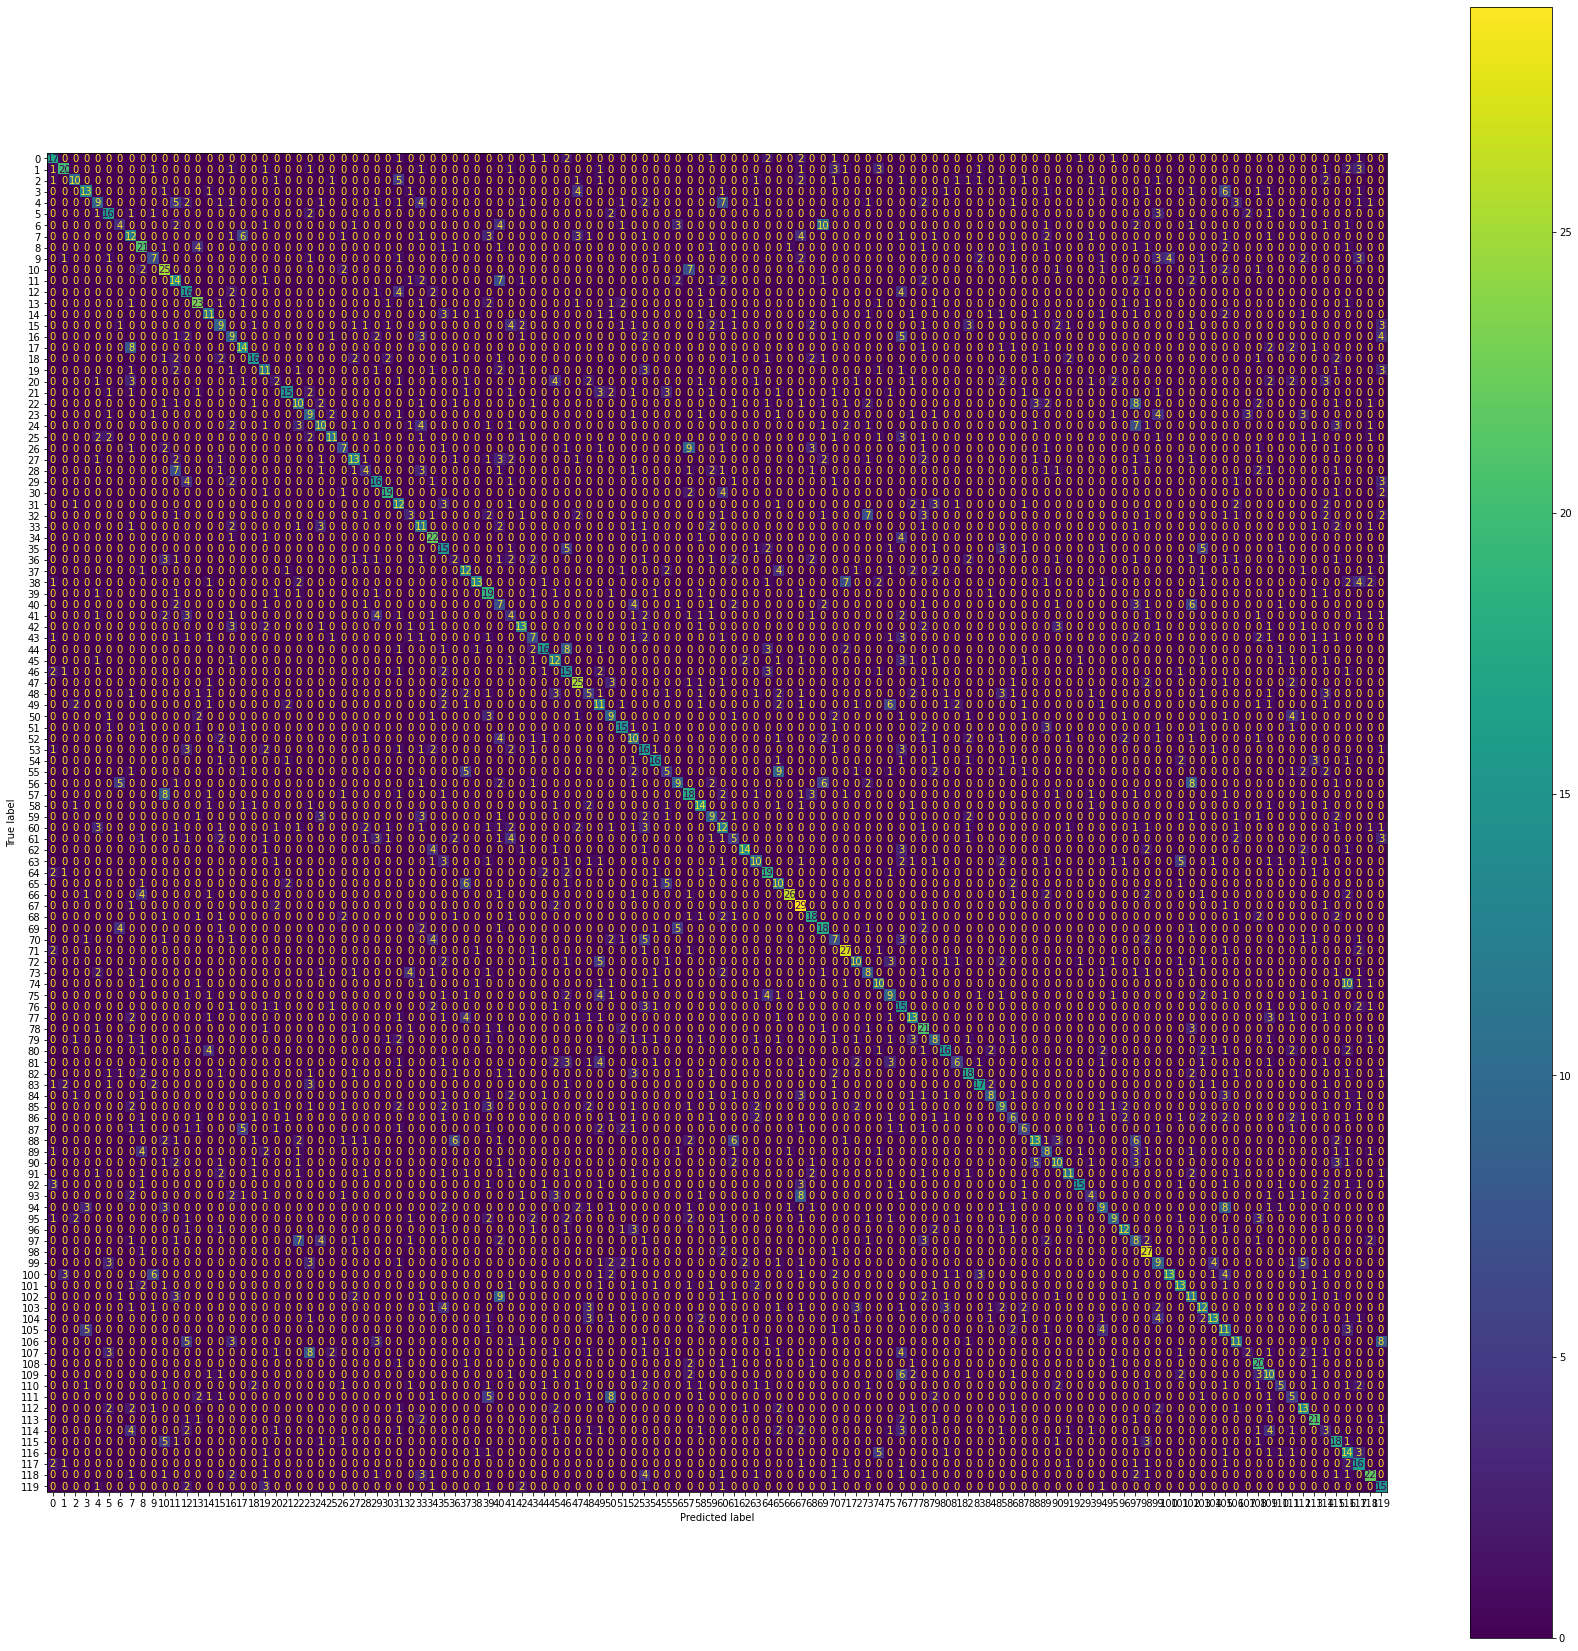

Classification Report
              precision    recall  f1-score   support

           0       0.47      0.55      0.51        31
           1       0.69      0.47      0.56        43
           2       0.56      0.29      0.38        34
           3       0.54      0.37      0.44        35
           4       0.36      0.20      0.25        46
           5       0.48      0.53      0.51        30
           6       0.25      0.12      0.17        32
           7       0.24      0.30      0.26        40
           8       0.44      0.54      0.48        39
           9       0.35      0.23      0.28        30
          10       0.42      0.58      0.49        43
          11       0.26      0.36      0.30        39
          12       0.34      0.53      0.42        30
          13       0.57      0.56      0.57        41
          14       0.39      0.37      0.38        30
          15       0.30      0.23      0.26        39
          16       0.24      0.29      0.26        31
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 5

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.1))

    model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.1))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_134 (MaxPooli  (None, 99, 99, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_134 (Ba  (None, 99, 99, 64)       448       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 99, 99, 64)        0         
                                                                 
 conv2d_135 (Conv2D)         (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 48, 48, 128)    

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model18_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 5.1008 - accuracy: 0.0169
Epoch 1: val_accuracy improved from -inf to 0.03919, saving model to model18_cnn.h5
515/515 [==============================] - 51s 94ms/step - loss: 5.1008 - accuracy: 0.0169 - val_loss: 4.5234 - val_accuracy: 0.0392
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 4.5413 - accuracy: 0.0291
Epoch 2: val_accuracy improved from 0.03919 to 0.04289, saving model to model18_cnn.h5
515/515 [==============================] - 48s 94ms/step - loss: 4.5413 - accuracy: 0.0291 - val_loss: 4.3491 - val_accuracy: 0.0429
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 4.4128 - accuracy: 0.0406
Epoch 3: val_accuracy improved from 0.04289 to 0.05127, saving model to model18_cnn.h5
515/515 [==============================] - 48s 93ms/step - loss: 4.4128 - accuracy: 0.0406 - val_loss: 4.2917 - val_accuracy: 0.0513
Epoch 4/100
515/515 [==============================]

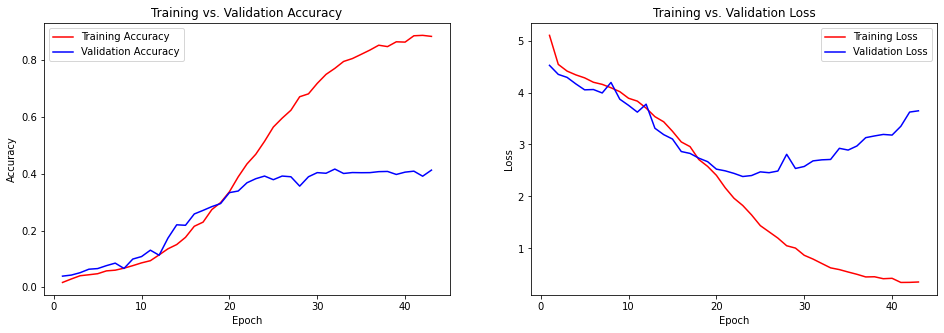

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 50ms/step - loss: 3.6478 - accuracy: 0.4129


Confusion Matrix


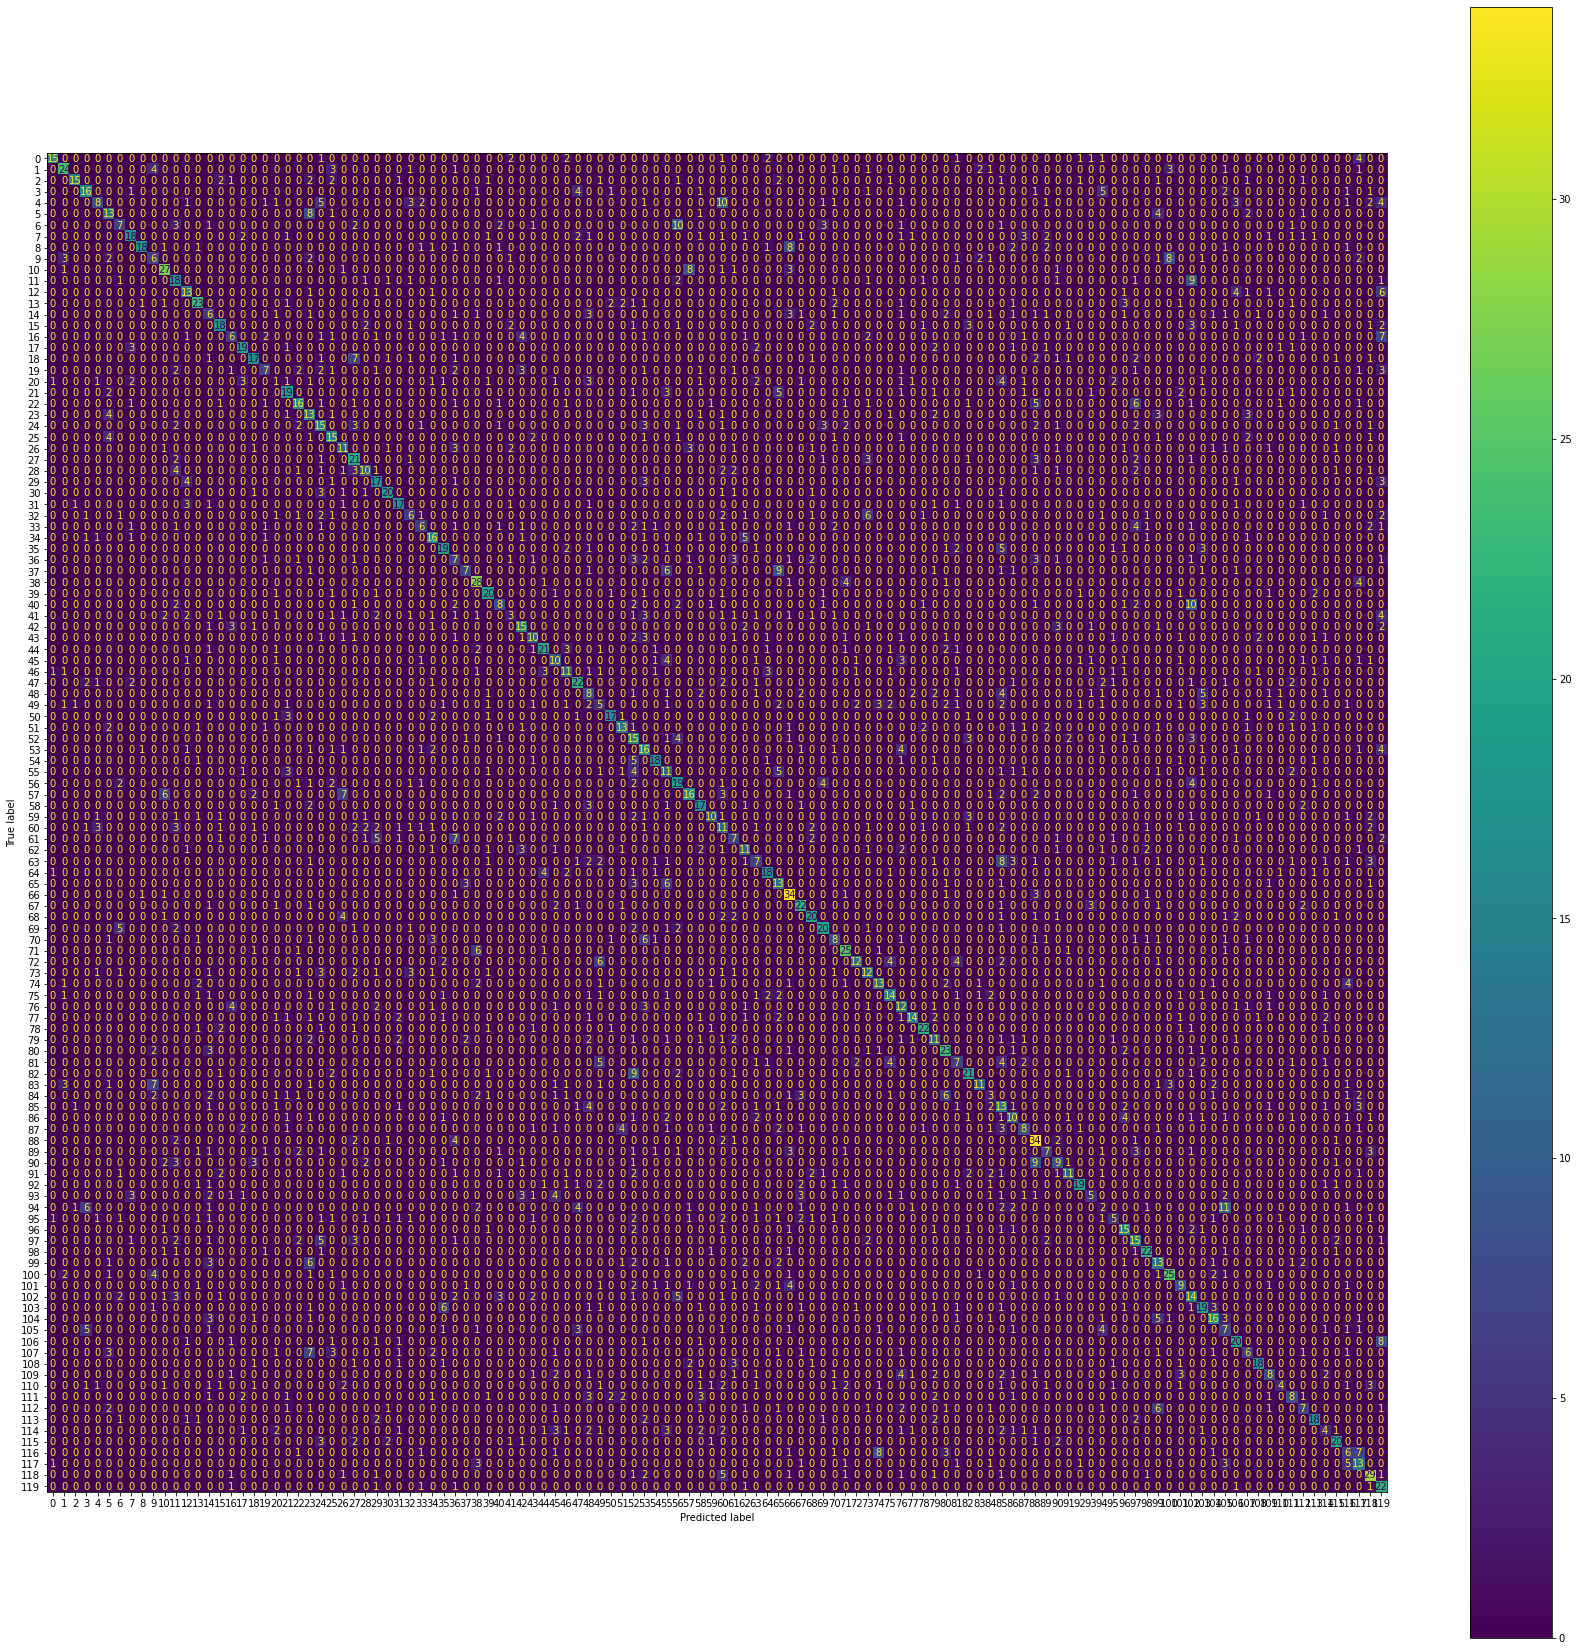

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.48      0.59        31
           1       0.65      0.56      0.60        43
           2       0.79      0.44      0.57        34
           3       0.48      0.46      0.47        35
           4       0.44      0.17      0.25        46
           5       0.36      0.43      0.39        30
           6       0.32      0.22      0.26        32
           7       0.55      0.45      0.49        40
           8       0.86      0.46      0.60        39
           9       0.23      0.20      0.21        30
          10       0.59      0.63      0.61        43
          11       0.35      0.46      0.40        39
          12       0.45      0.43      0.44        30
          13       0.62      0.56      0.59        41
          14       0.16      0.20      0.18        30
          15       0.56      0.46      0.51        39
          16       0.30      0.19      0.24        31
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 6

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_144 (Conv2D)         (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 99, 99, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_144 (Ba  (None, 99, 99, 64)       448       
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 99, 99, 64)        0         
                                                                 
 conv2d_145 (Conv2D)         (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 48, 48, 128)    

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model18_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.9871 - accuracy: 0.0157
Epoch 1: val_accuracy improved from -inf to 0.03377, saving model to model18_cnn.h5
515/515 [==============================] - 51s 94ms/step - loss: 4.9871 - accuracy: 0.0157 - val_loss: 4.5195 - val_accuracy: 0.0338
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 4.5002 - accuracy: 0.0333
Epoch 2: val_accuracy improved from 0.03377 to 0.03919, saving model to model18_cnn.h5
515/515 [==============================] - 48s 94ms/step - loss: 4.5002 - accuracy: 0.0333 - val_loss: 4.3742 - val_accuracy: 0.0392
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 4.4073 - accuracy: 0.0392
Epoch 3: val_accuracy improved from 0.03919 to 0.05719, saving model to model18_cnn.h5
515/515 [==============================] - 48s 94ms/step - loss: 4.4073 - accuracy: 0.0392 - val_loss: 4.2124 - val_accuracy: 0.0572
Epoch 4/100
515/515 [==============================]

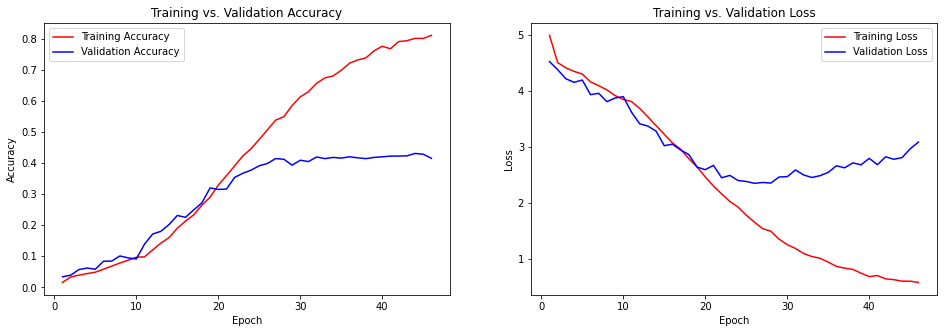

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 47ms/step - loss: 3.0840 - accuracy: 0.4156


Confusion Matrix


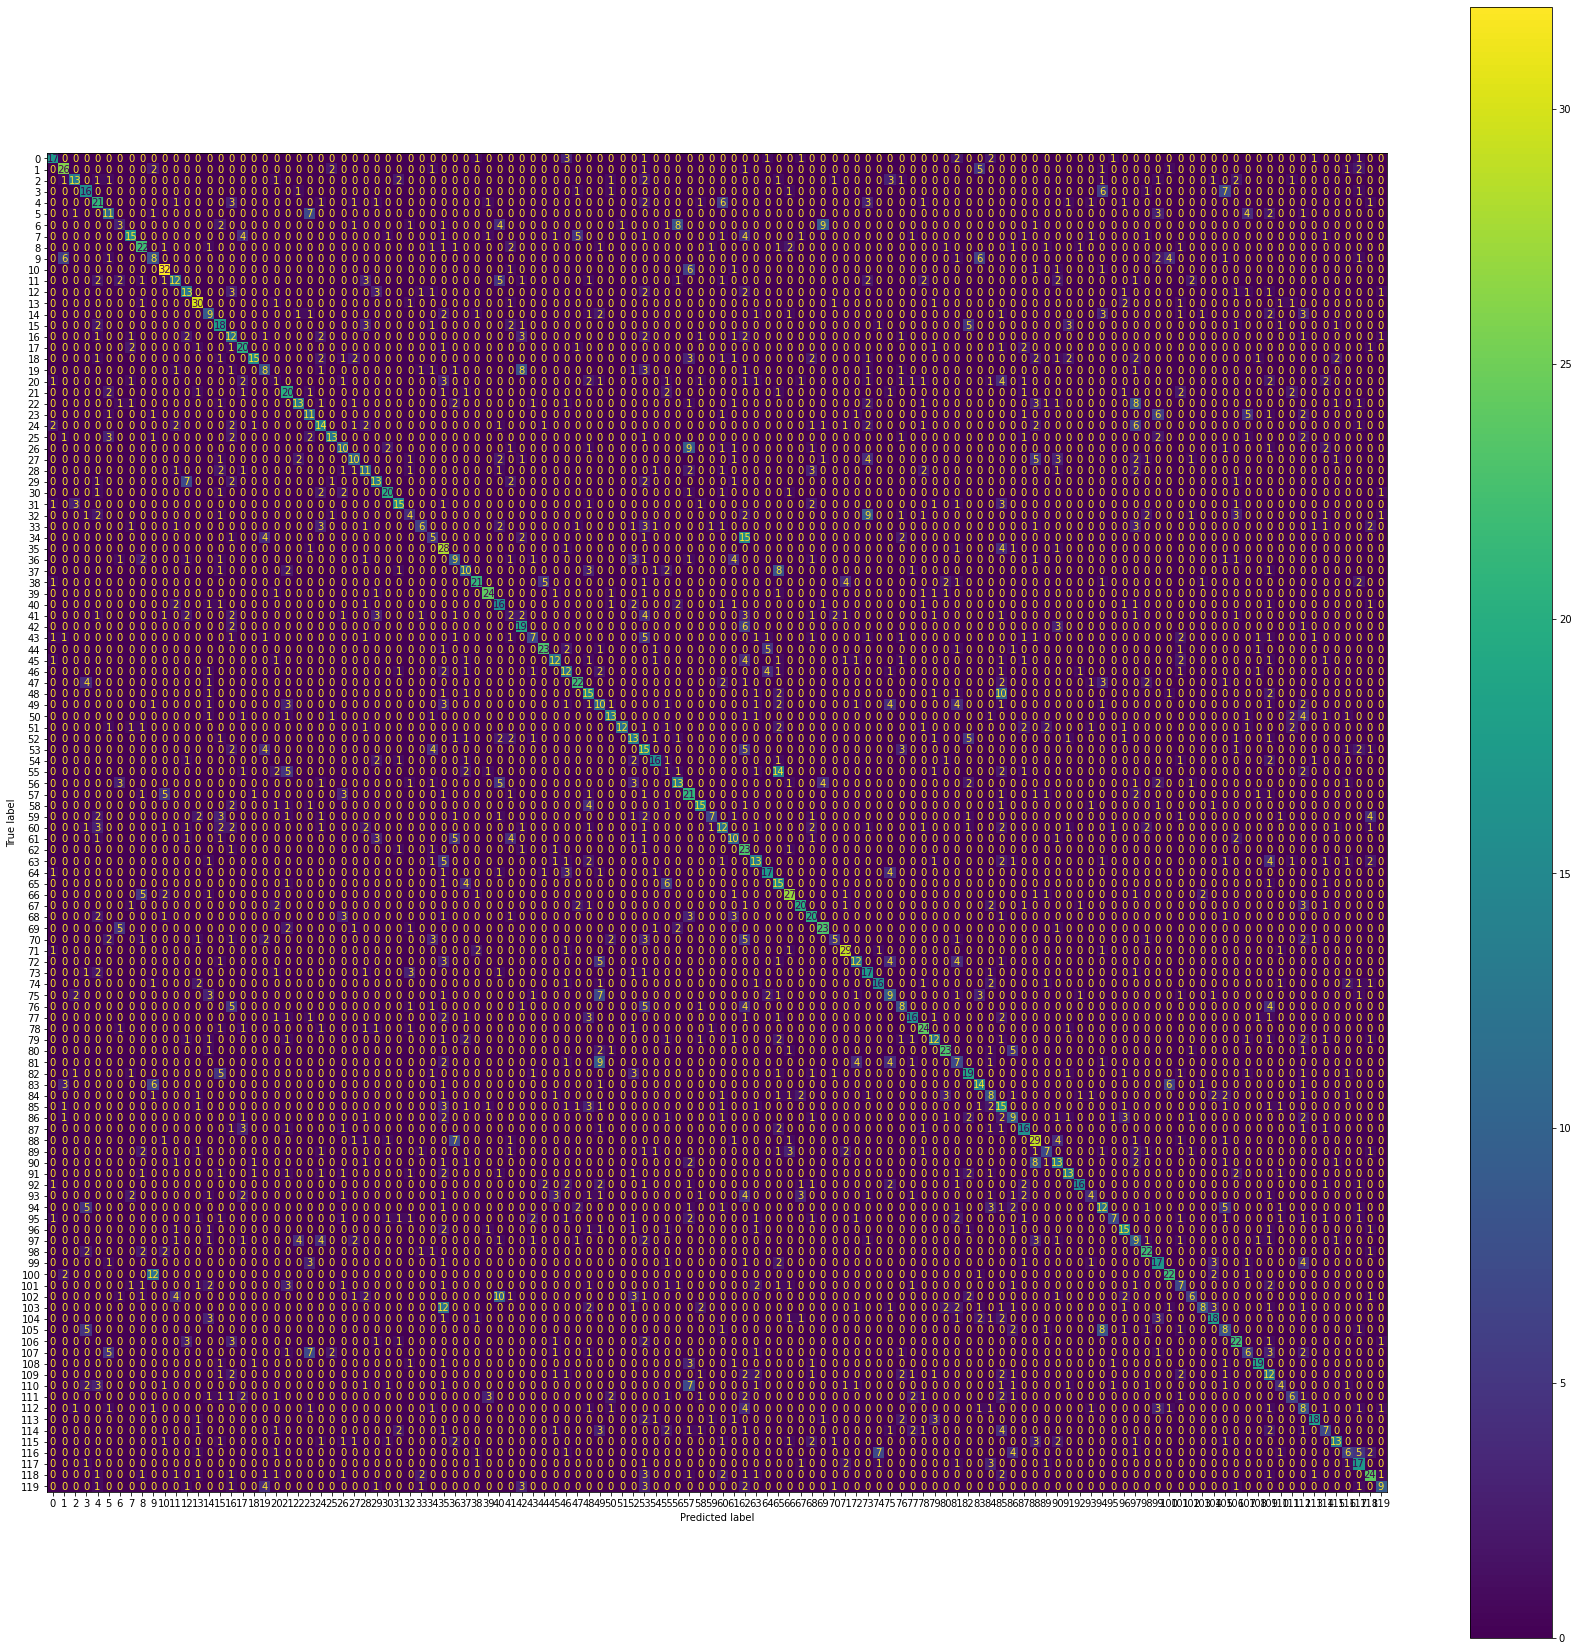

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        31
           1       0.62      0.60      0.61        43
           2       0.62      0.38      0.47        34
           3       0.42      0.46      0.44        35
           4       0.44      0.46      0.45        46
           5       0.38      0.37      0.37        30
           6       0.18      0.09      0.12        32
           7       0.56      0.38      0.45        40
           8       0.52      0.56      0.54        39
           9       0.23      0.27      0.25        30
          10       0.65      0.74      0.70        43
          11       0.43      0.31      0.36        39
          12       0.39      0.43      0.41        30
          13       0.65      0.73      0.69        41
          14       0.28      0.30      0.29        30
          15       0.36      0.46      0.40        39
          16       0.22      0.39      0.28        31
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 8

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=384, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_42 (Bat  (None, 99, 99, 64)       448       
 chNormalization)                                                
                                                                 
 dropout_50 (Dropout)        (None, 99, 99, 64)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 97, 97, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 48, 48, 128)     

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model21_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.9172 - accuracy: 0.0159
Epoch 1: val_accuracy improved from -inf to 0.02317, saving model to model21_cnn.h5
515/515 [==============================] - 49s 92ms/step - loss: 4.9172 - accuracy: 0.0159 - val_loss: 4.5936 - val_accuracy: 0.0232
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 4.5716 - accuracy: 0.0302
Epoch 2: val_accuracy improved from 0.02317 to 0.03771, saving model to model21_cnn.h5
515/515 [==============================] - 47s 91ms/step - loss: 4.5716 - accuracy: 0.0302 - val_loss: 4.3871 - val_accuracy: 0.0377
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 4.4576 - accuracy: 0.0339
Epoch 3: val_accuracy improved from 0.03771 to 0.04782, saving model to model21_cnn.h5
515/515 [==============================] - 47s 91ms/step - loss: 4.4576 - accuracy: 0.0339 - val_loss: 4.2481 - val_accuracy: 0.0478
Epoch 4/100
515/515 [==============================]

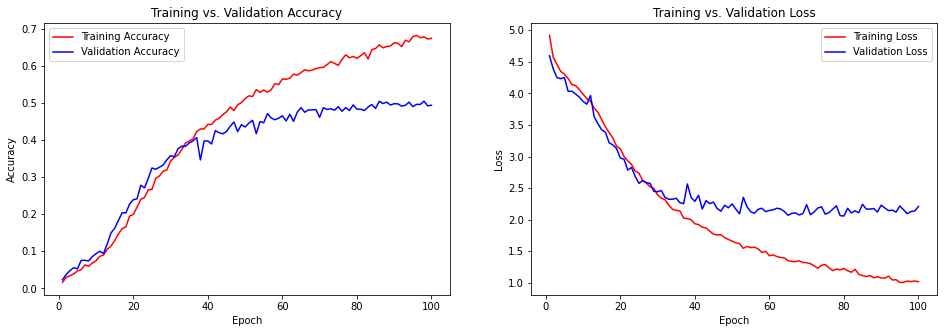

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 5s 43ms/step - loss: 2.2090 - accuracy: 0.4940


Confusion Matrix


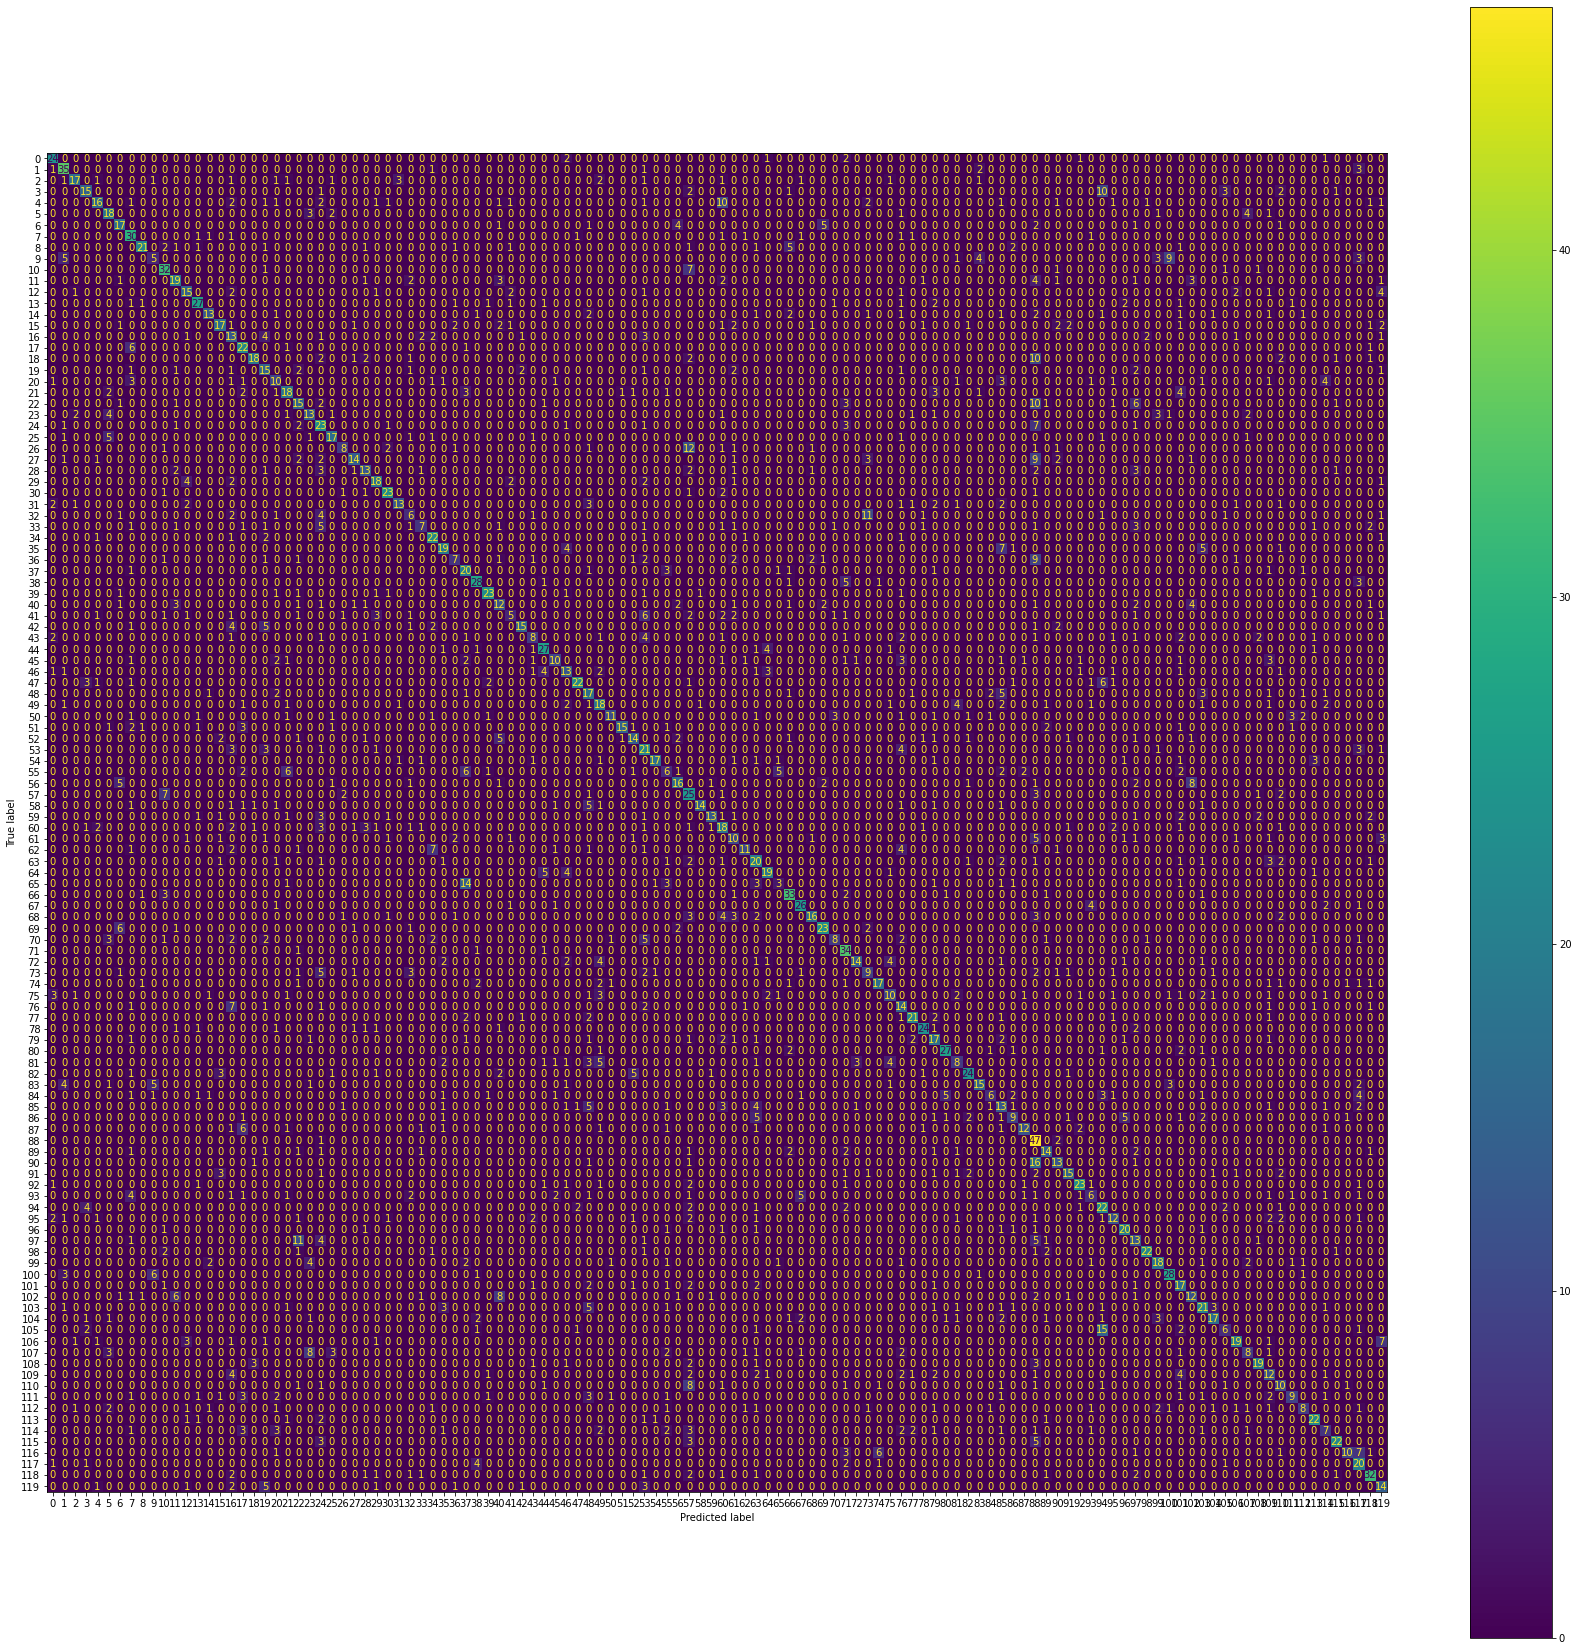

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.77      0.70        31
           1       0.64      0.81      0.71        43
           2       0.71      0.50      0.59        34
           3       0.56      0.43      0.48        35
           4       0.62      0.35      0.44        46
           5       0.45      0.60      0.51        30
           6       0.47      0.53      0.50        32
           7       0.46      0.75      0.57        40
           8       0.81      0.54      0.65        39
           9       0.28      0.17      0.21        30
          10       0.60      0.74      0.67        43
          11       0.51      0.49      0.50        39
          12       0.50      0.50      0.50        30
          13       0.73      0.66      0.69        41
          14       0.65      0.43      0.52        30
          15       0.59      0.44      0.50        39
          16       0.21      0.42      0.28        31
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 9

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(200, 200, 3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# model = Sequential()
# model.add(i_model)

# model.add(GlobalAveragePooling2D())
# model.add(Dense(128))
# model.add(Dropout(0.2))
# model.add(Dense(120, activation = 'softmax'))

# model.build([None, 200, 200, 3])
# model.summary()

x = i_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model = keras.Model(i_model.input, outputs)

for layer in i_model.layers:
    layer.trainable = False

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
model_checkpoint = ModelCheckpoint("model24_transfer_aug.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
history = model.fit(train_generator, 
                         epochs=5, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/5
515/515 [==============================] - ETA: 0s - loss: 1.2372 - accuracy: 0.6859
Epoch 00001: val_accuracy improved from -inf to 0.79887, saving model to model24_transfer_aug.h5
515/515 [==============================] - 55s 75ms/step - loss: 1.2372 - accuracy: 0.6859 - val_loss: 0.6968 - val_accuracy: 0.7989
Epoch 2/5
515/515 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.8031
Epoch 00002: val_accuracy improved from 0.79887 to 0.79985, saving model to model24_transfer_aug.h5
515/515 [==============================] - 36s 71ms/step - loss: 0.6762 - accuracy: 0.8031 - val_loss: 0.6753 - val_accuracy: 0.7999
Epoch 3/5
515/515 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.8252
Epoch 00003: val_accuracy improved from 0.79985 to 0.81144, saving model to model24_transfer_aug.h5
515/515 [==============================] - 36s 71ms/step - loss: 0.5764 - accuracy: 0.8252 - val_loss: 0.6649 - val_accuracy: 0.8114
Epoch 4/5
515/515 [

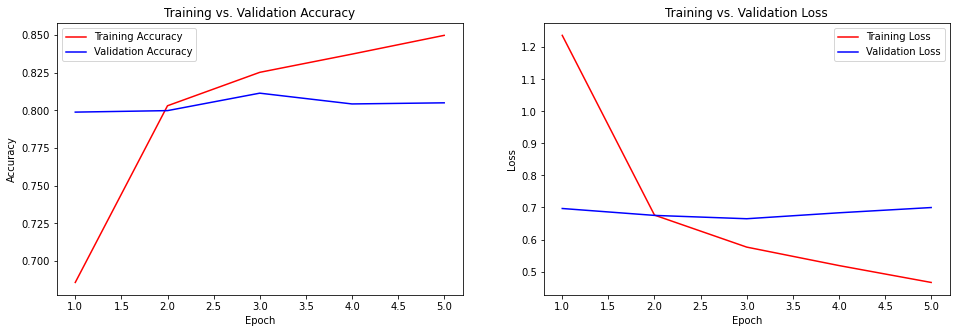

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 7s 56ms/step - loss: 0.6998 - accuracy: 0.8050


Confusion Matrix


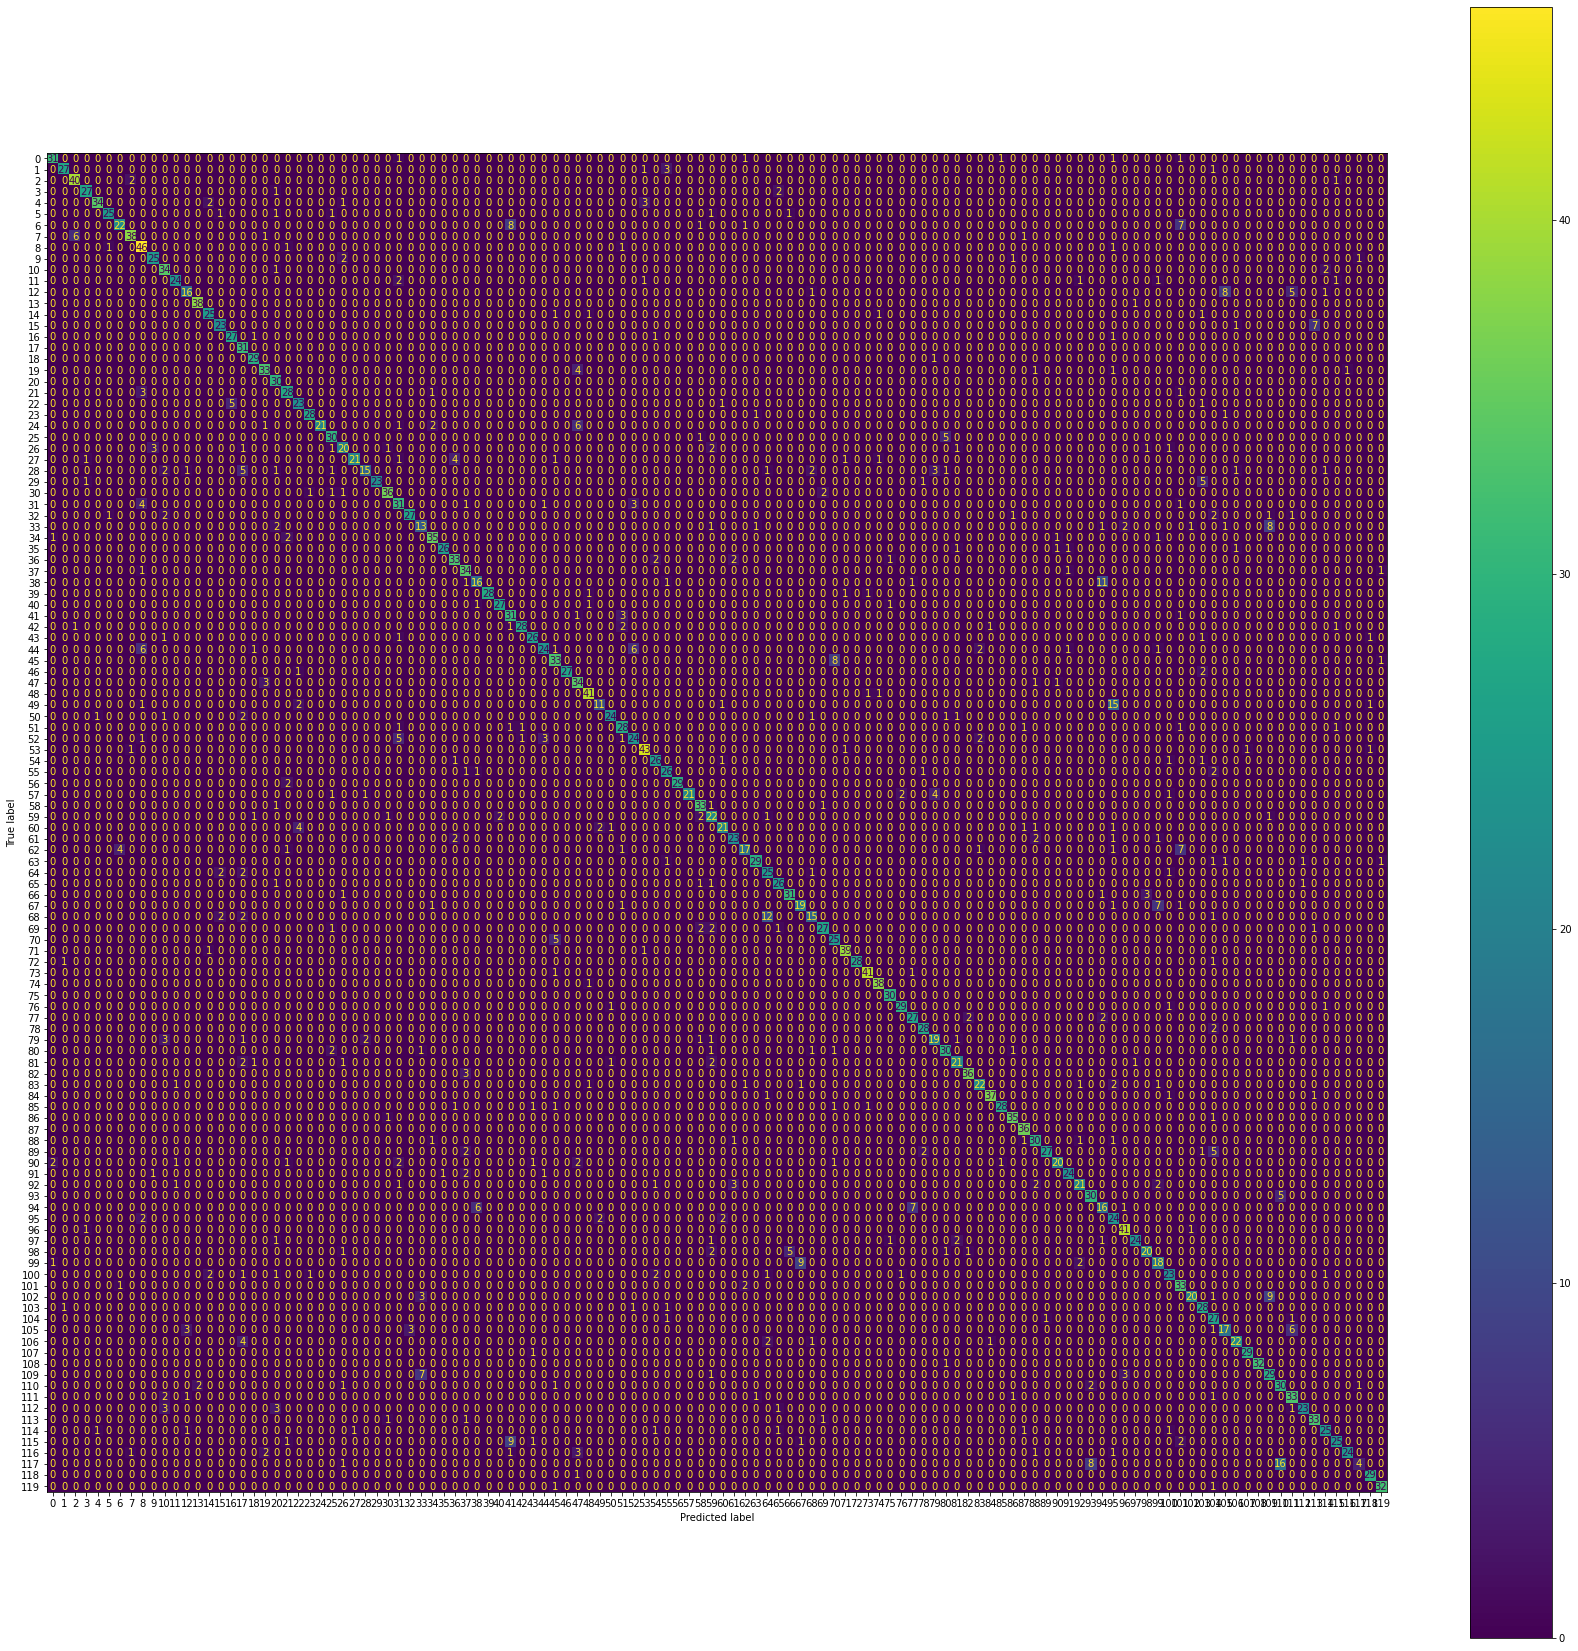

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.93      0.84      0.89        32
           2       0.85      0.93      0.89        43
           3       0.90      0.90      0.90        30
           4       0.94      0.85      0.89        40
           5       0.93      0.83      0.88        30
           6       0.81      0.56      0.67        39
           7       0.90      0.83      0.86        46
           8       0.72      0.92      0.81        50
           9       0.86      0.86      0.86        29
          10       0.71      0.92      0.80        37
          11       0.89      0.80      0.84        30
          12       0.73      0.52      0.60        31
          13       0.95      0.97      0.96        39
          14       0.83      0.86      0.85        29
          15       0.82      0.74      0.78        31
          16       0.84      0.90      0.87        30
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

### Model 10

In [ ]:
# For each layer in the pretrained model
for layer in model.layers:
    # Unfreeze the layer
    layer.trainable = True

In [ ]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
model_checkpoint = ModelCheckpoint("model24_2_transfer_aug.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
history = model.fit(train_generator, 
                         epochs=25, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/25
515/515 [==============================] - ETA: 0s - loss: 2.8096 - accuracy: 0.2799
Epoch 00001: val_accuracy improved from -inf to 0.26719, saving model to model24_2_transfer_aug.h5
515/515 [==============================] - 82s 142ms/step - loss: 2.8096 - accuracy: 0.2799 - val_loss: 2.9890 - val_accuracy: 0.2672
Epoch 2/25
515/515 [==============================] - ETA: 0s - loss: 1.8888 - accuracy: 0.4590
Epoch 00002: val_accuracy improved from 0.26719 to 0.46241, saving model to model24_2_transfer_aug.h5
515/515 [==============================] - 72s 139ms/step - loss: 1.8888 - accuracy: 0.4590 - val_loss: 1.9198 - val_accuracy: 0.4624
Epoch 3/25
515/515 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.5517
Epoch 00003: val_accuracy did not improve from 0.46241
515/515 [==============================] - 70s 136ms/step - loss: 1.5150 - accuracy: 0.5517 - val_loss: 2.2792 - val_accuracy: 0.4077
Epoch 4/25
515/515 [==============================] - 

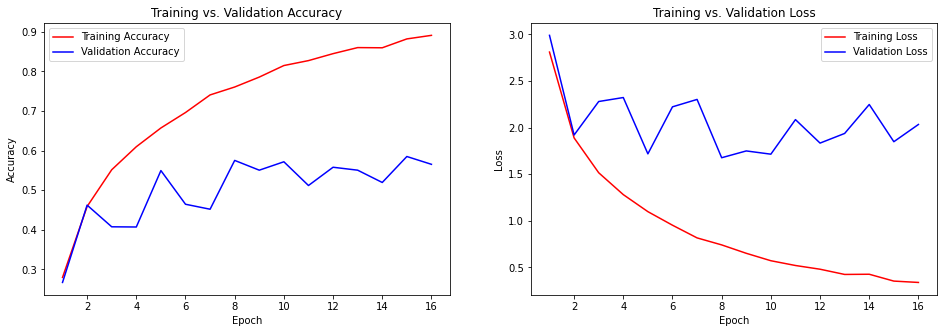

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

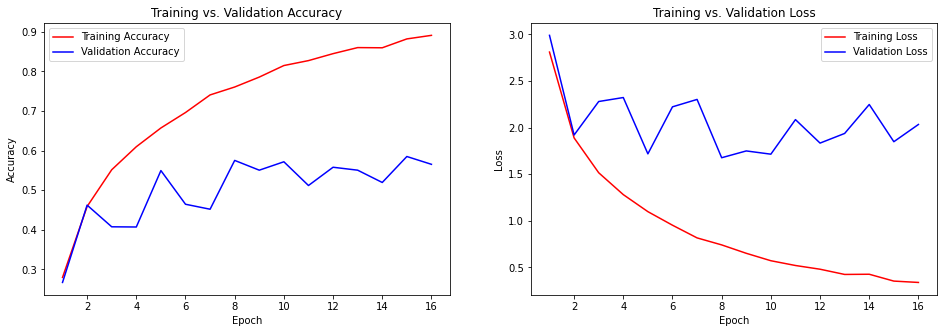

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 49ms/step - loss: 2.0329 - accuracy: 0.5654


Confusion Matrix


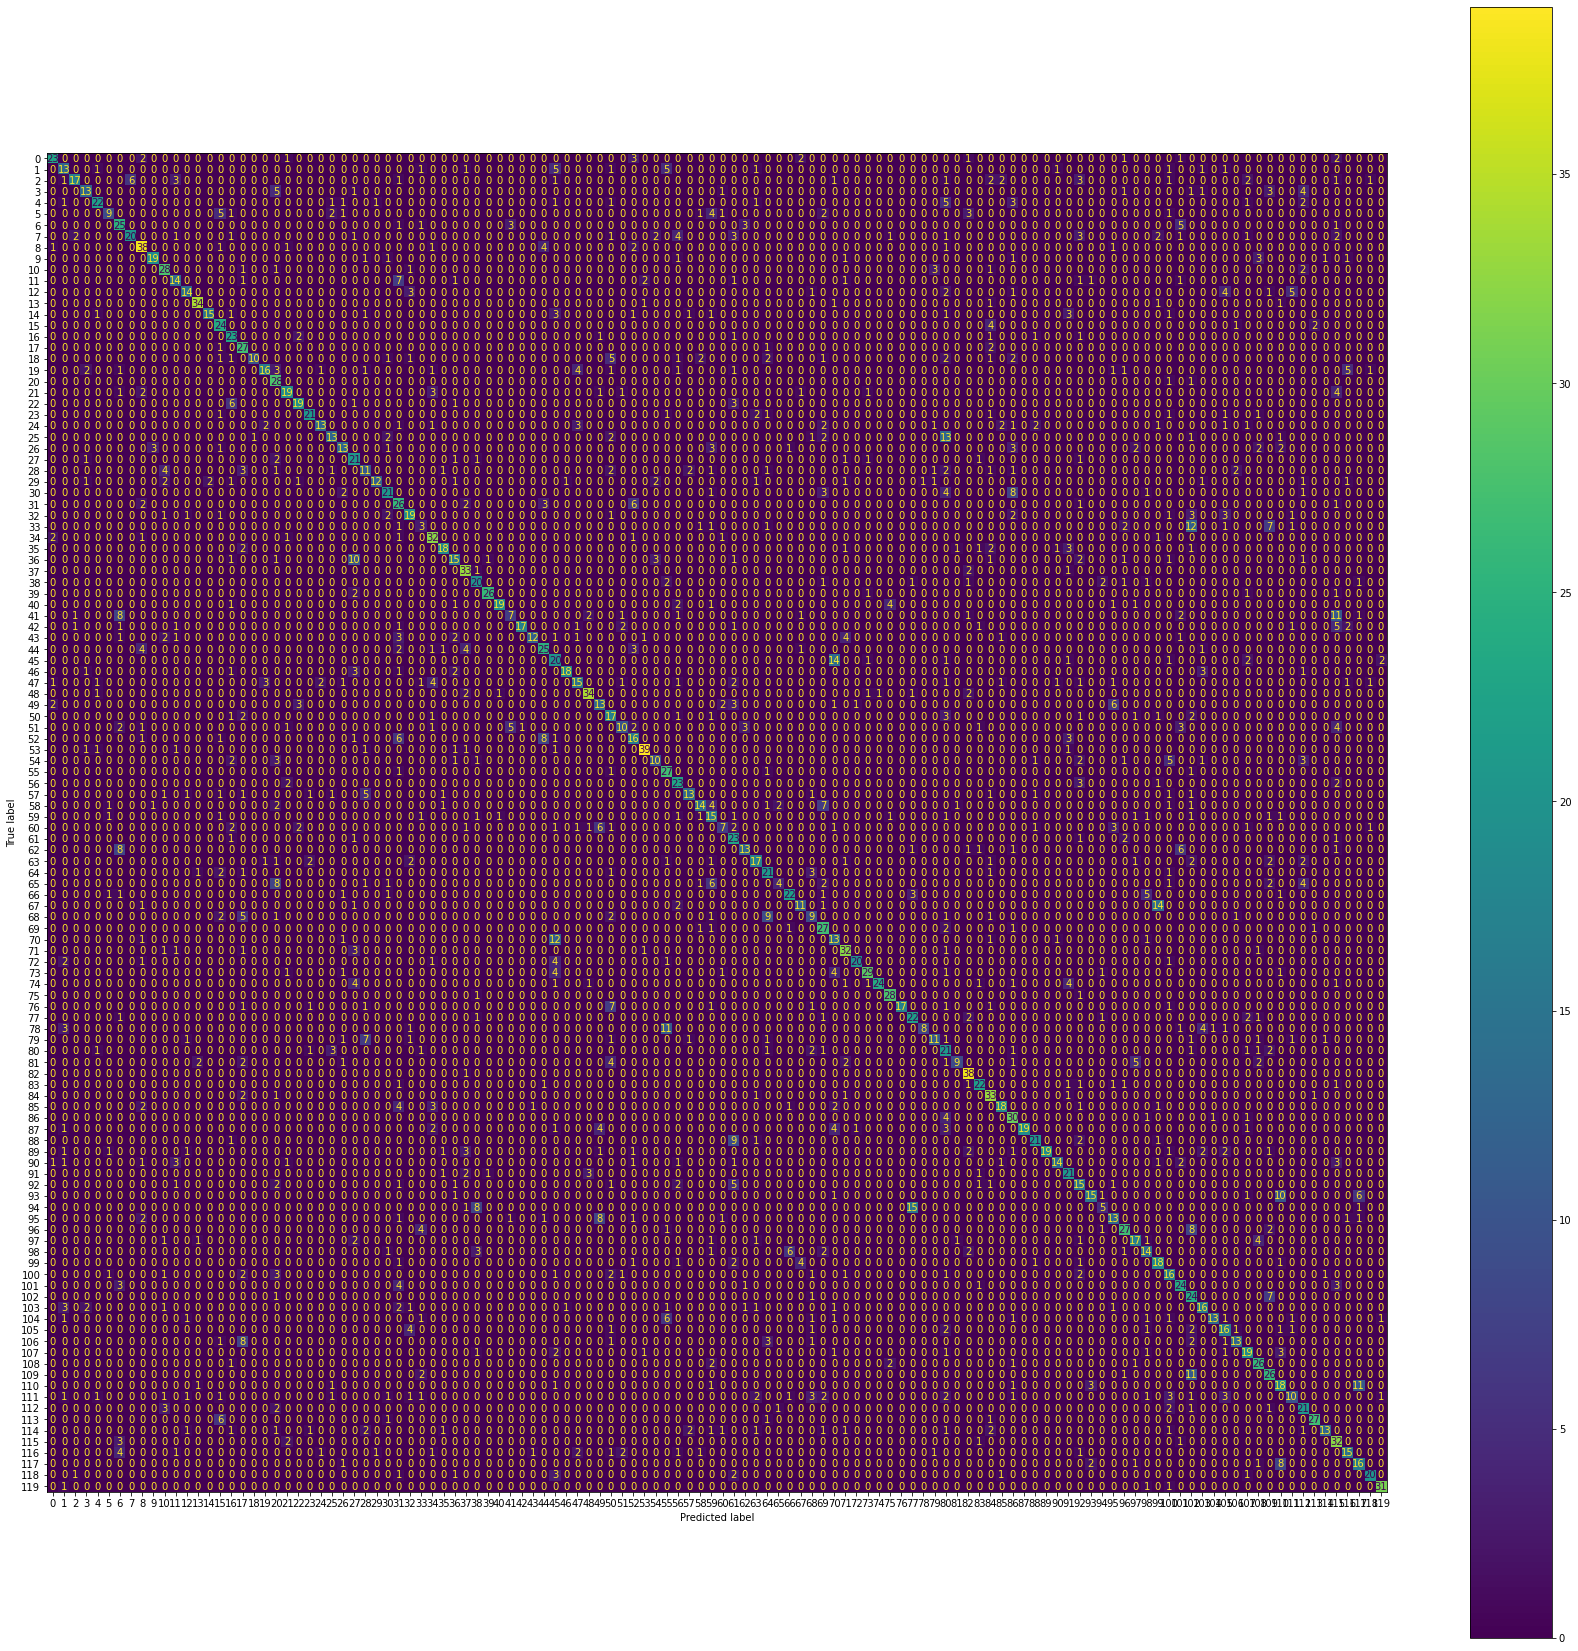

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.64      0.70        36
           1       0.45      0.41      0.43        32
           2       0.77      0.40      0.52        43
           3       0.62      0.43      0.51        30
           4       0.76      0.55      0.64        40
           5       0.64      0.30      0.41        30
           6       0.42      0.64      0.51        39
           7       0.77      0.43      0.56        46
           8       0.64      0.76      0.70        50
           9       0.83      0.66      0.73        29
          10       0.61      0.76      0.67        37
          11       0.52      0.47      0.49        30
          12       0.67      0.45      0.54        31
          13       0.87      0.87      0.87        39
          14       0.88      0.52      0.65        29
          15       0.48      0.77      0.59        31
          16       0.50      0.77      0.61        30
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 11

In [ ]:
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(200, 200, 3))

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# model = Sequential()
# model.add(i_model)

# model.add(GlobalAveragePooling2D())
# model.add(Dense(128))
# model.add(Dropout(0.2))
# model.add(Dense(120, activation = 'softmax'))

# model.build([None, 200, 200, 3])
# model.summary()

x = i_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model = keras.Model(i_model.input, outputs)

for layer in i_model.layers:
    layer.trainable = False

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 99, 99, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
model_checkpoint = ModelCheckpoint("model24_transfer_aug.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
history = model.fit(train_generator, 
                         epochs=5, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/5
514/515 [============================>.] - ETA: 0s - loss: 1.2916 - accuracy: 0.6745
Epoch 00001: val_accuracy improved from -inf to 0.80281, saving model to model24_transfer_aug.h5
515/515 [==============================] - 47s 62ms/step - loss: 1.2911 - accuracy: 0.6746 - val_loss: 0.6848 - val_accuracy: 0.8028
Epoch 2/5
515/515 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.7966
Epoch 00002: val_accuracy improved from 0.80281 to 0.80601, saving model to model24_transfer_aug.h5
515/515 [==============================] - 30s 59ms/step - loss: 0.6862 - accuracy: 0.7966 - val_loss: 0.6514 - val_accuracy: 0.8060
Epoch 3/5
515/515 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.8288
Epoch 00003: val_accuracy improved from 0.80601 to 0.81587, saving model to model24_transfer_aug.h5
515/515 [==============================] - 30s 59ms/step - loss: 0.5694 - accuracy: 0.8288 - val_loss: 0.6499 - val_accuracy: 0.8159
Epoch 4/5
515/515 [

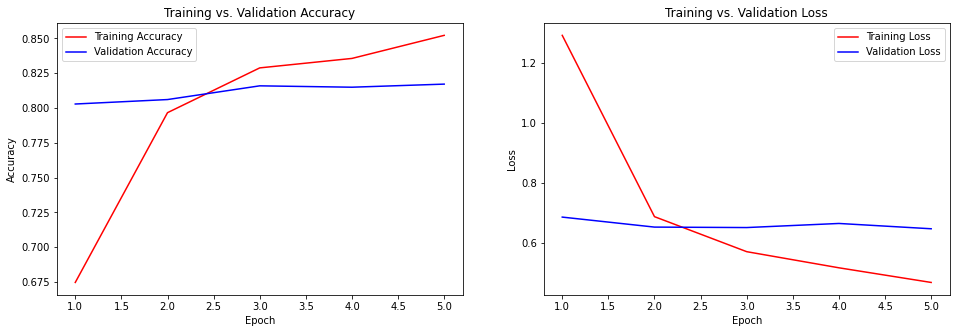

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 47ms/step - loss: 0.6458 - accuracy: 0.8171


Confusion Matrix


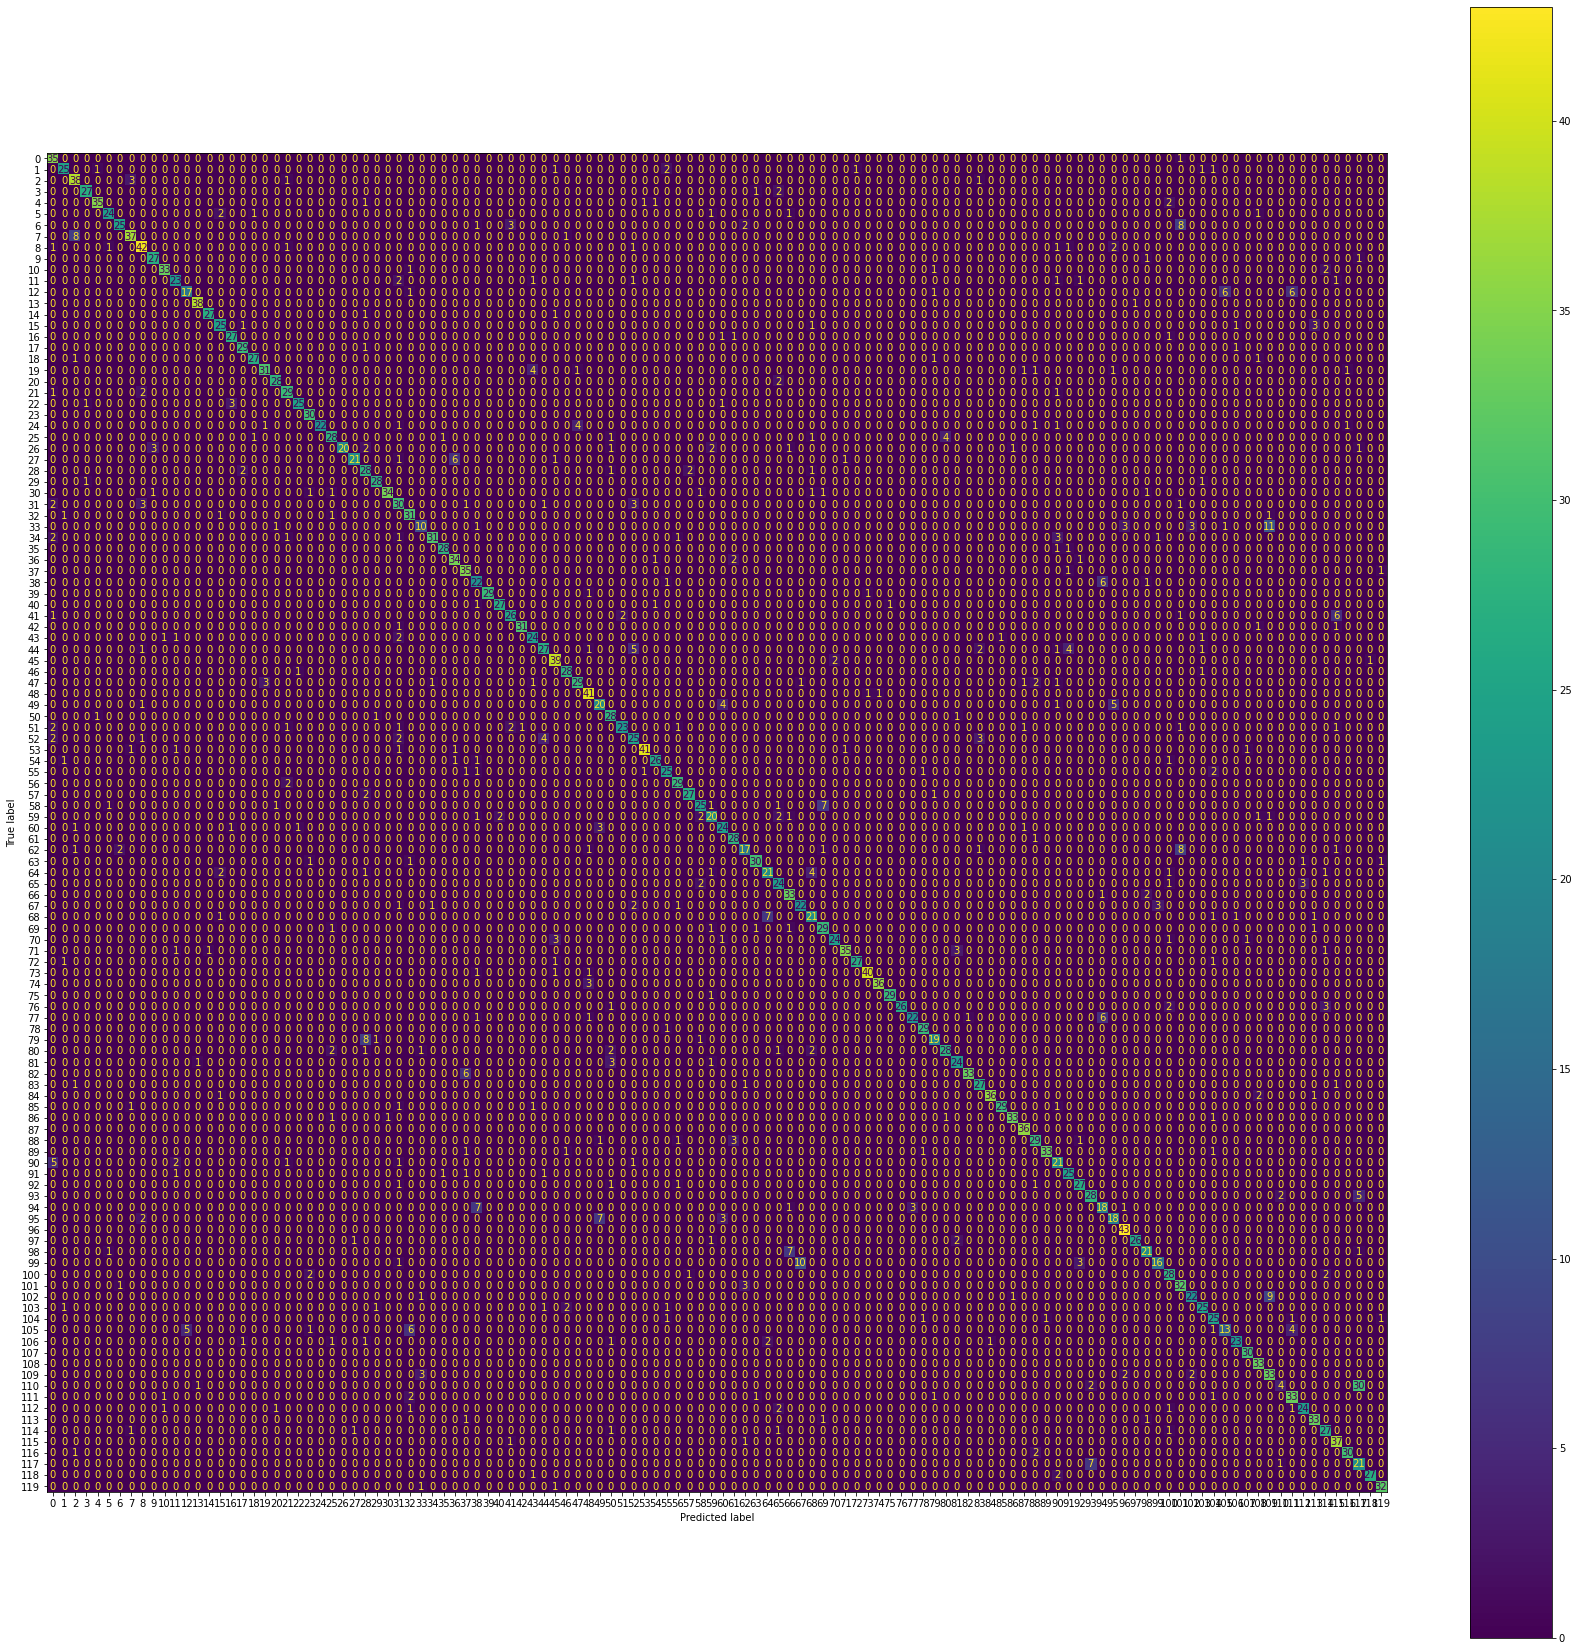

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.97      0.80        36
           1       0.86      0.78      0.82        32
           2       0.75      0.88      0.81        43
           3       0.93      0.90      0.92        30
           4       0.95      0.88      0.91        40
           5       0.89      0.80      0.84        30
           6       0.89      0.64      0.75        39
           7       0.86      0.80      0.83        46
           8       0.81      0.84      0.82        50
           9       0.87      0.93      0.90        29
          10       0.92      0.89      0.90        37
          11       0.79      0.77      0.78        30
          12       0.77      0.55      0.64        31
          13       0.95      0.97      0.96        39
          14       0.96      0.93      0.95        29
          15       0.78      0.81      0.79        31
          16       0.87      0.90      0.89        30
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

In [ ]:
# For each layer in the pretrained model
for layer in model.layers[:-9]:
    # Unfreeze the layer
    layer.trainable = True

In [ ]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
model_checkpoint = ModelCheckpoint("model24_2_transfer_aug.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
history = model.fit(train_generator, 
                         epochs=25, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/25
515/515 [==============================] - ETA: 0s - loss: 2.8143 - accuracy: 0.2780
Epoch 00001: val_accuracy improved from -inf to 0.31033, saving model to model24_2_transfer_aug.h5
515/515 [==============================] - 78s 137ms/step - loss: 2.8143 - accuracy: 0.2780 - val_loss: 2.5951 - val_accuracy: 0.3103
Epoch 2/25
515/515 [==============================] - ETA: 0s - loss: 1.8858 - accuracy: 0.4616
Epoch 00002: val_accuracy improved from 0.31033 to 0.42642, saving model to model24_2_transfer_aug.h5
515/515 [==============================] - 69s 134ms/step - loss: 1.8858 - accuracy: 0.4616 - val_loss: 2.1208 - val_accuracy: 0.4264
Epoch 3/25
515/515 [==============================] - ETA: 0s - loss: 1.5168 - accuracy: 0.5515
Epoch 00003: val_accuracy did not improve from 0.42642
515/515 [==============================] - 68s 131ms/step - loss: 1.5168 - accuracy: 0.5515 - val_loss: 2.4302 - val_accuracy: 0.3880
Epoch 4/25
515/515 [==============================] - 

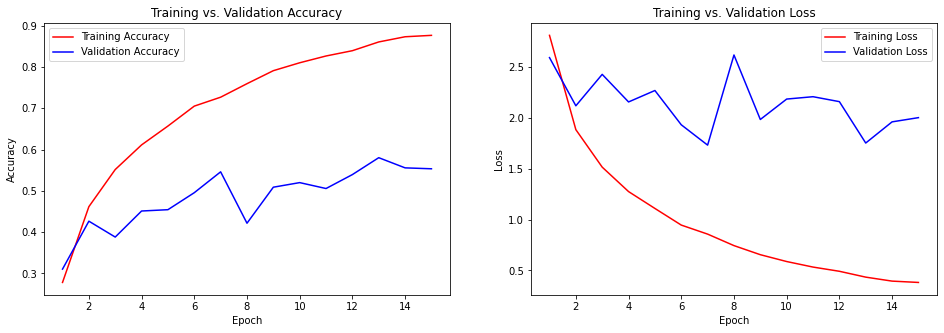

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 6s 50ms/step - loss: 2.0041 - accuracy: 0.5534


Confusion Matrix


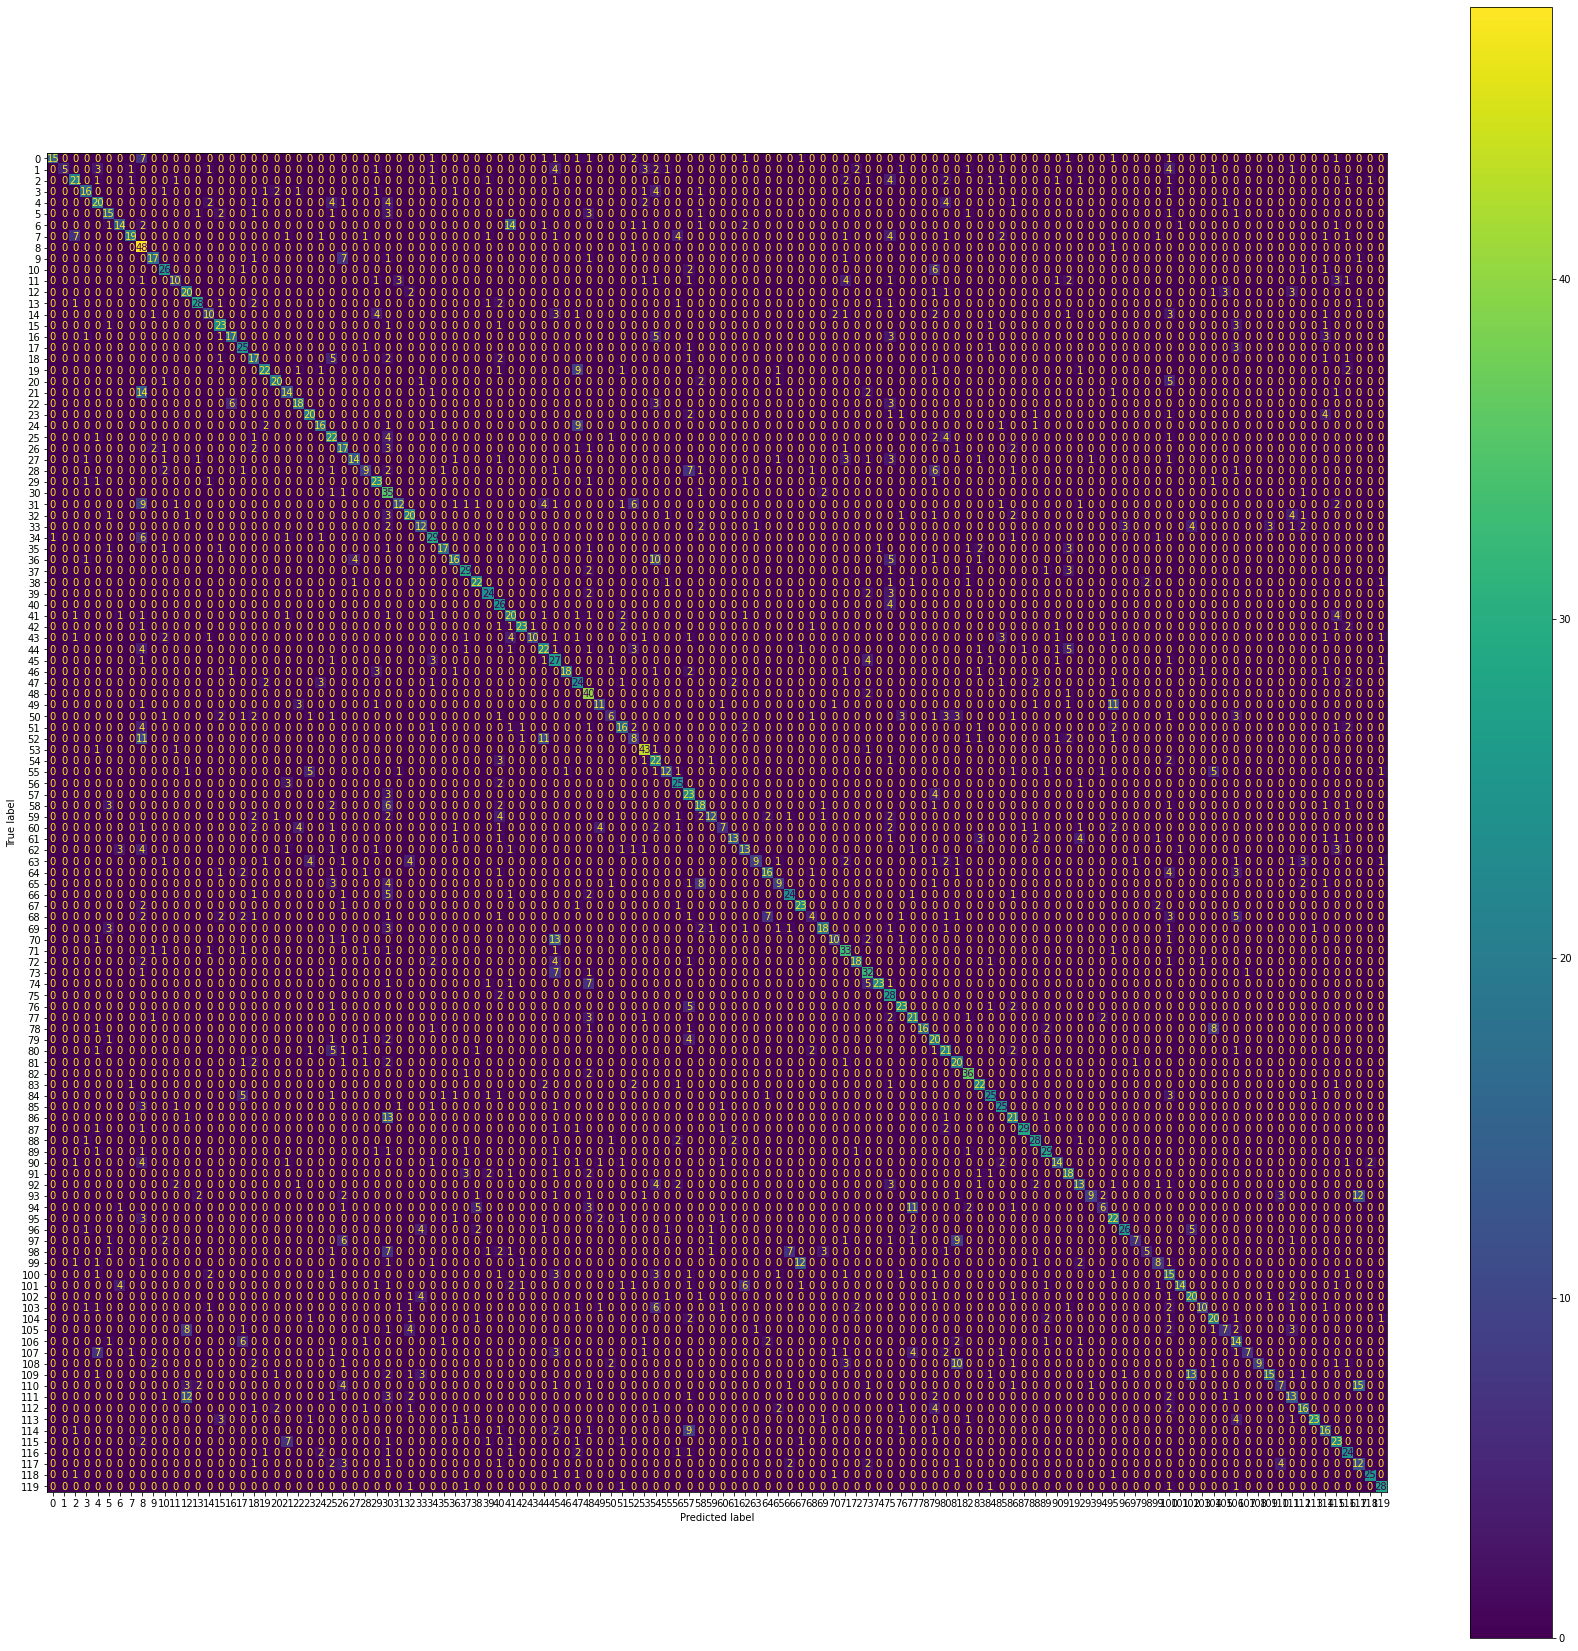

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.42      0.58        36
           1       1.00      0.16      0.27        32
           2       0.60      0.49      0.54        43
           3       0.70      0.53      0.60        30
           4       0.47      0.50      0.48        40
           5       0.52      0.50      0.51        30
           6       0.61      0.36      0.45        39
           7       0.83      0.41      0.55        46
           8       0.35      0.96      0.51        50
           9       0.71      0.59      0.64        29
          10       0.63      0.70      0.67        37
          11       0.62      0.33      0.43        30
          12       0.43      0.65      0.52        31
          13       0.82      0.72      0.77        39
          14       0.53      0.34      0.42        29
          15       0.62      0.74      0.68        31
          16       0.71      0.57      0.63        30
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 12

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=192, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 99, 99, 32)       224       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 99, 99, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 48, 48, 64)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model21_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
515/515 [==============================] - ETA: 0s - loss: 4.7536 - accuracy: 0.0175
Epoch 1: val_accuracy improved from -inf to 0.02835, saving model to model21_cnn.h5
515/515 [==============================] - 43s 80ms/step - loss: 4.7536 - accuracy: 0.0175 - val_loss: 4.5773 - val_accuracy: 0.0283
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 4.5548 - accuracy: 0.0275
Epoch 2: val_accuracy improved from 0.02835 to 0.04042, saving model to model21_cnn.h5
515/515 [==============================] - 40s 78ms/step - loss: 4.5548 - accuracy: 0.0275 - val_loss: 4.3862 - val_accuracy: 0.0404
Epoch 3/100
515/515 [==============================] - ETA: 0s - loss: 4.4581 - accuracy: 0.0345
Epoch 3: val_accuracy did not improve from 0.04042
515/515 [==============================] - 40s 78ms/step - loss: 4.4581 - accuracy: 0.0345 - val_loss: 4.4725 - val_accuracy: 0.0397
Epoch 4/100
515/515 [==============================] - ETA: 0s - loss: 4.3916 - accuracy

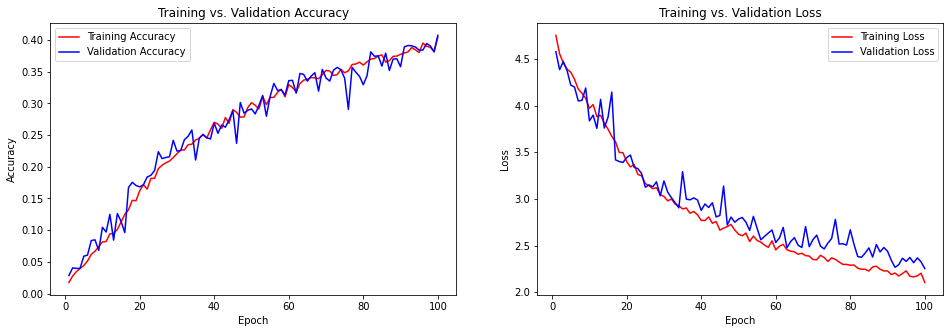

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 5s 43ms/step - loss: 2.2531 - accuracy: 0.4074


Confusion Matrix


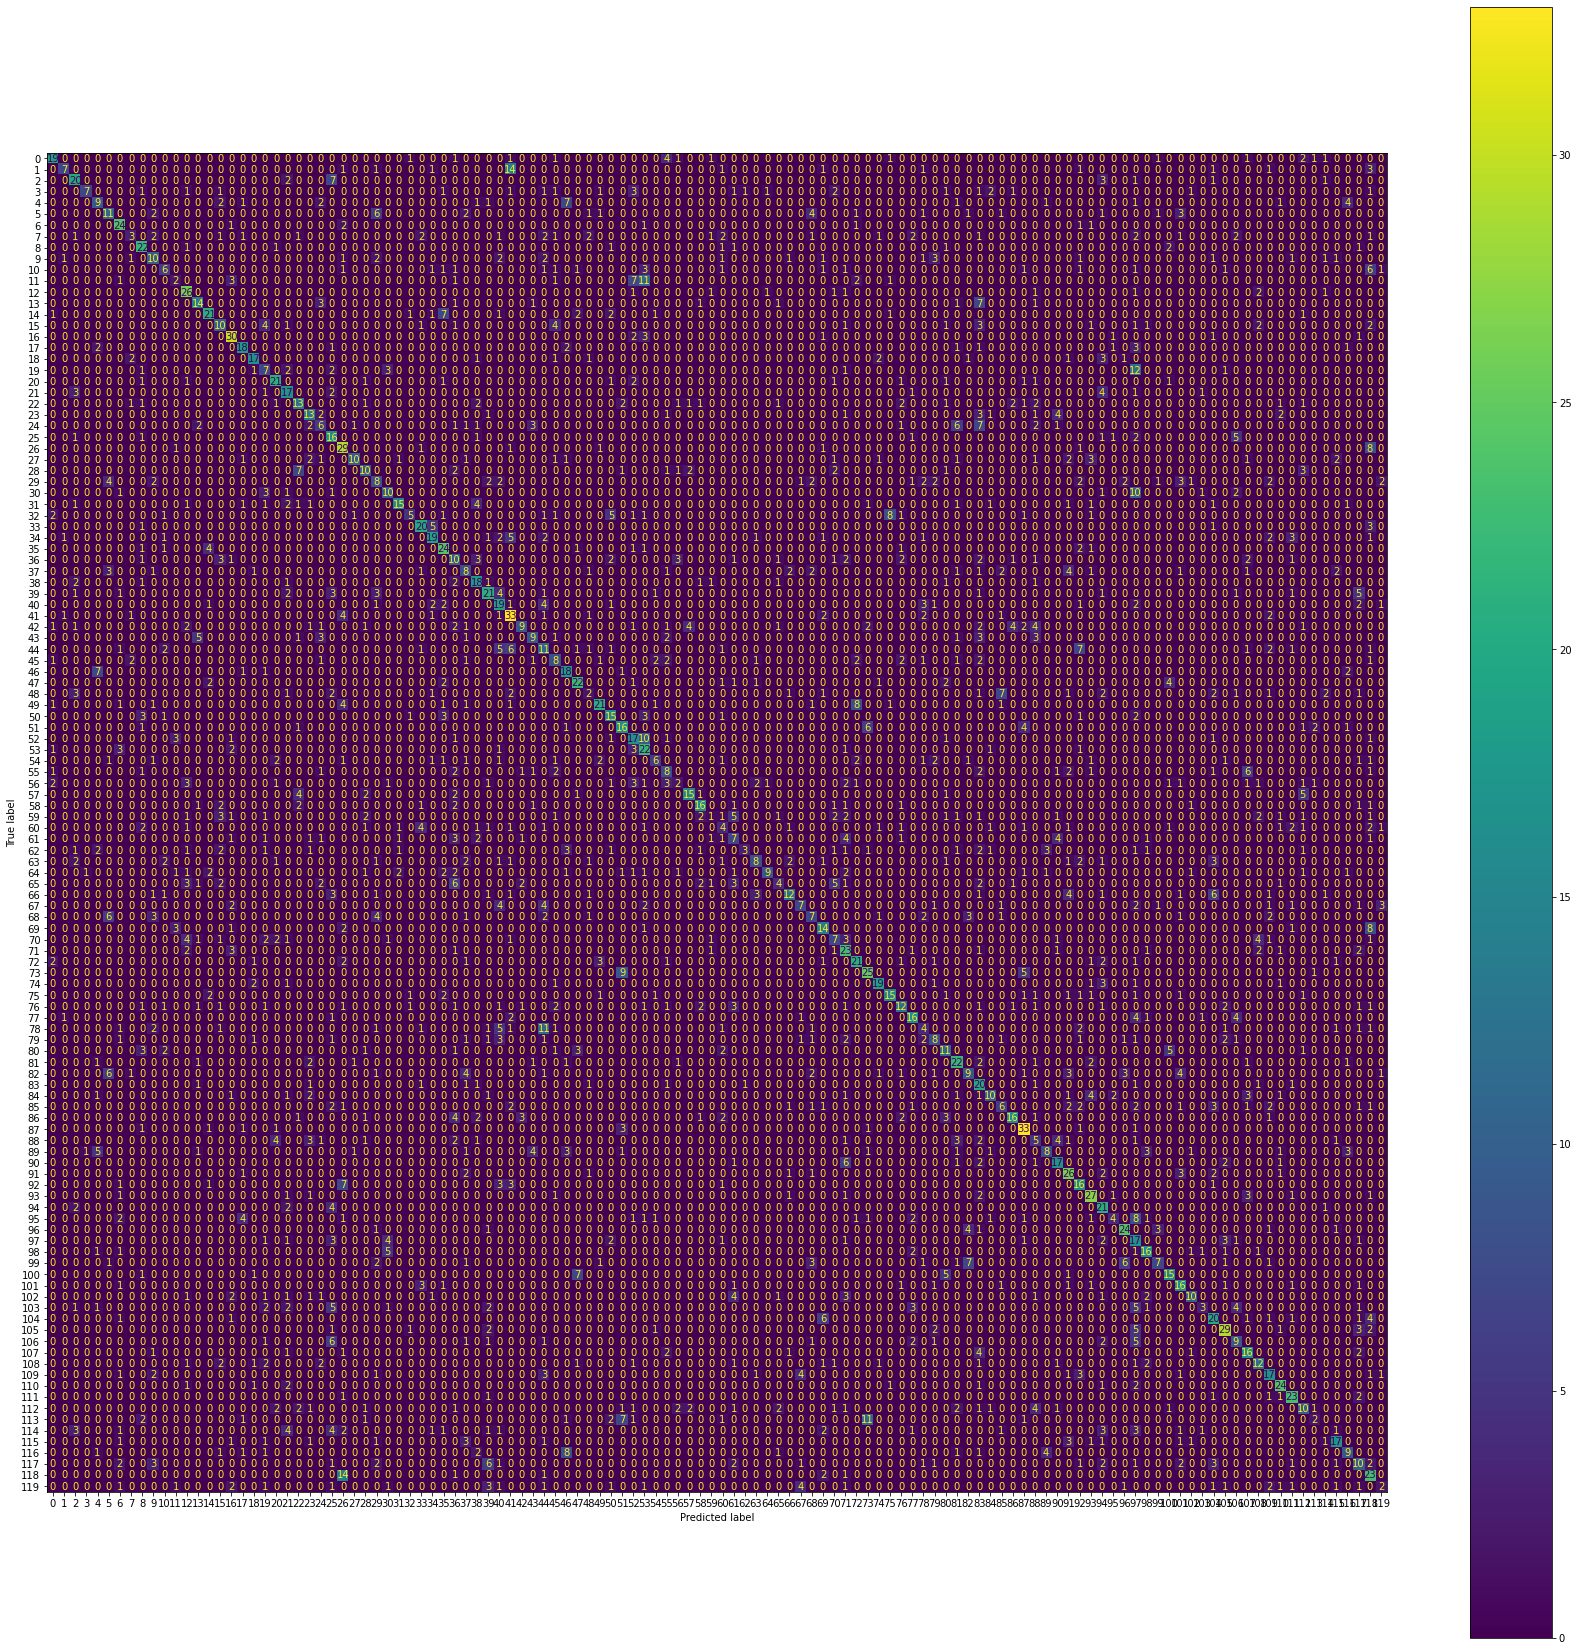

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.53      0.57        36
           1       0.64      0.21      0.32        33
           2       0.48      0.57      0.52        35
           3       0.78      0.23      0.36        30
           4       0.30      0.29      0.30        31
           5       0.34      0.31      0.32        36
           6       0.51      0.77      0.62        31
           7       0.27      0.10      0.14        31
           8       0.48      0.71      0.57        31
           9       0.32      0.32      0.32        31
          10       0.33      0.20      0.25        30
          11       0.18      0.07      0.10        29
          12       0.51      0.72      0.60        36
          13       0.50      0.47      0.48        30
          14       0.62      0.54      0.58        39
          15       0.31      0.30      0.31        33
          16       0.57      0.77      0.65        39
     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Model 13

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.4))

    model.add(Conv2D(filters=81, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization(renorm=True))
    model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    #output layer
    model.add(Dense(120, activation="softmax"))
    return model

In [ ]:
model = buildModel().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 99, 99, 16)       112       
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 99, 99, 16)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 48, 48, 32)      

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard , CSVLogger, ReduceLROnPlateau
import datetime
model_checkpoint = ModelCheckpoint("model21_cnn.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
callbacks = [model_checkpoint, early_stopping]

In [ ]:
epoch = 100
validation_steps = np.ceil(valid_generator.n/BATCH_SIZE)
steps_per_epoch = np.ceil(train_generator.n/BATCH_SIZE)

In [ ]:
from tensorflow.keras.optimizers import Adam
model_adam = buildModel()
optimizer = Adam(learning_rate=0.0001)
model_adam.compile('adam', loss='categorical_crossentropy', metrics=["accuracy"])
history = model_adam.fit(train_generator, 
                         epochs=epoch, 
                         steps_per_epoch = steps_per_epoch, 
                         validation_data=valid_generator, 
                         validation_steps=validation_steps, 
                         callbacks=callbacks)

Epoch 1/100
514/515 [============================>.] - ETA: 0s - loss: 4.6807 - accuracy: 0.0204
Epoch 1: val_accuracy improved from -inf to 0.03352, saving model to model21_cnn.h5
515/515 [==============================] - 30s 55ms/step - loss: 4.6806 - accuracy: 0.0204 - val_loss: 4.5045 - val_accuracy: 0.0335
Epoch 2/100
515/515 [==============================] - ETA: 0s - loss: 4.4710 - accuracy: 0.0324
Epoch 2: val_accuracy improved from 0.03352 to 0.04807, saving model to model21_cnn.h5
515/515 [==============================] - 29s 55ms/step - loss: 4.4710 - accuracy: 0.0324 - val_loss: 4.3192 - val_accuracy: 0.0481
Epoch 3/100
514/515 [============================>.] - ETA: 0s - loss: 4.3530 - accuracy: 0.0457
Epoch 3: val_accuracy did not improve from 0.04807
515/515 [==============================] - 28s 55ms/step - loss: 4.3527 - accuracy: 0.0458 - val_loss: 4.7906 - val_accuracy: 0.0261
Epoch 4/100
514/515 [============================>.] - ETA: 0s - loss: 4.3013 - accuracy

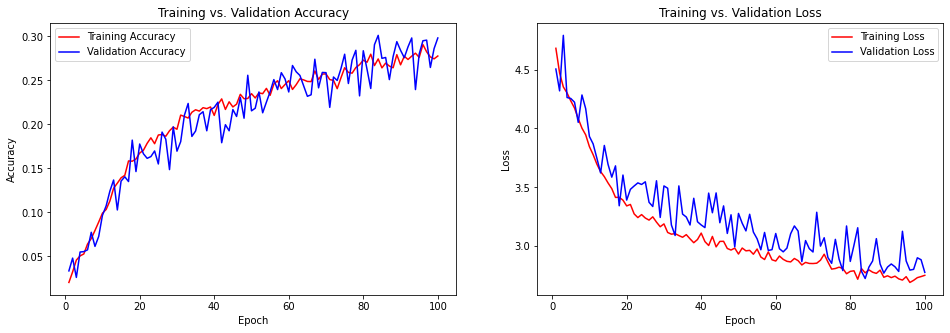

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (16, 5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
results = model_adam.evaluate(valid_generator, batch_size=BATCH_SIZE)

127/127 [==============================] - 5s 42ms/step - loss: 2.7780 - accuracy: 0.2982


Confusion Matrix


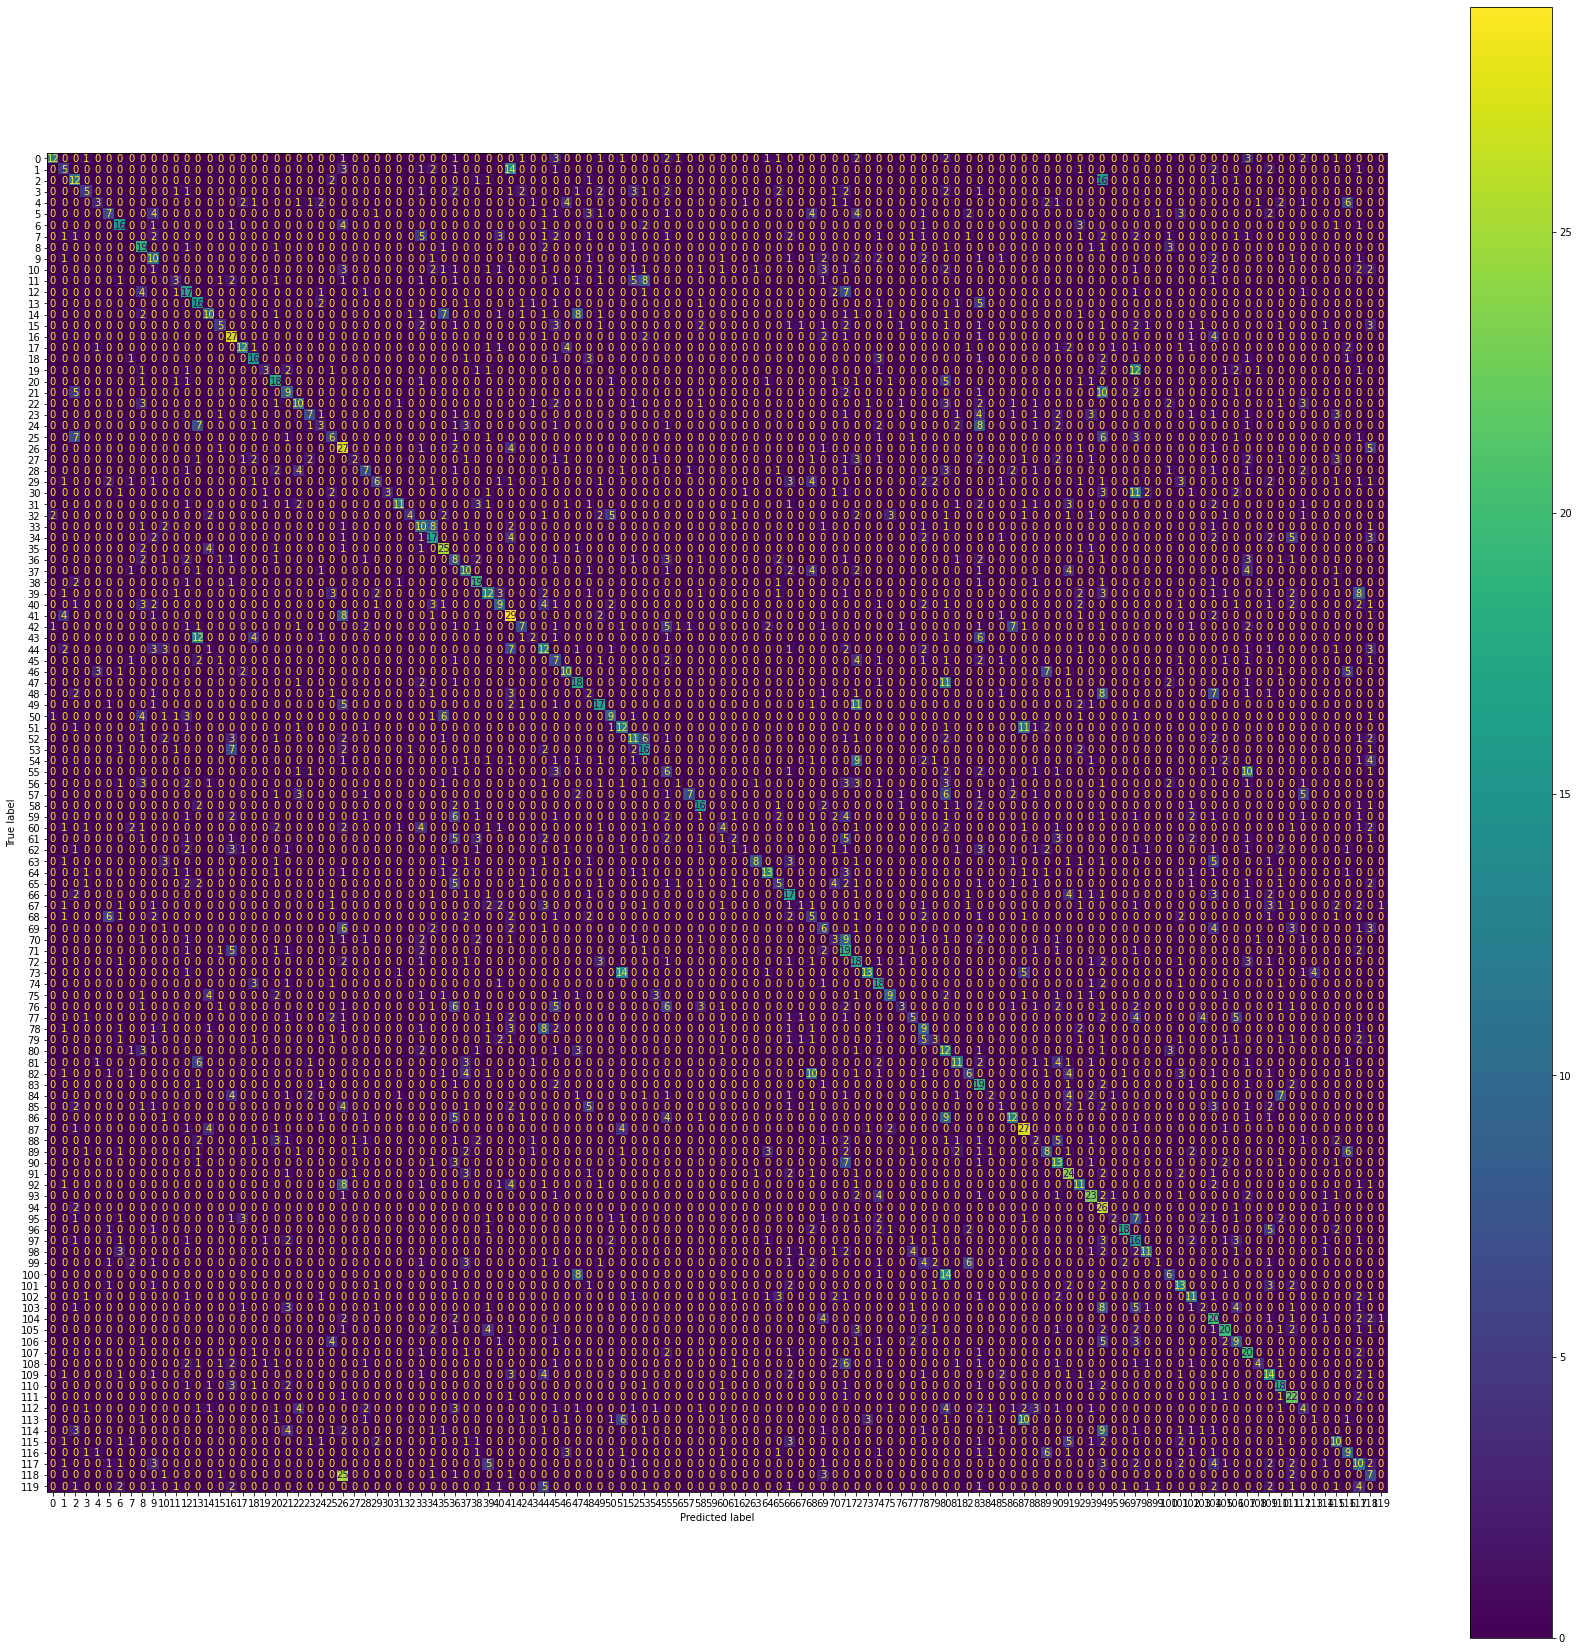

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.33      0.46        36
           1       0.20      0.15      0.17        33
           2       0.26      0.34      0.30        35
           3       0.36      0.17      0.23        30
           4       0.33      0.10      0.15        31
           5       0.33      0.19      0.25        36
           6       0.43      0.52      0.47        31
           7       0.00      0.00      0.00        31
           8       0.33      0.61      0.43        31
           9       0.23      0.32      0.27        31
          10       0.00      0.00      0.00        30
          11       0.27      0.10      0.15        29
          12       0.35      0.47      0.40        36
          13       0.28      0.53      0.37        30
          14       0.34      0.26      0.29        39
          15       0.36      0.15      0.21        33
          16       0.42      0.69      0.52        39
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

#Confution Matrix and Classification Report
Y_pred = model_adam.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
print('Classification Report')
print(classification_report(valid_generator.classes, y_pred))

## Summary and conclusions

* I could probably get better results using this data. Model 12 (learned after the last class) shows that it works well with fewer parameters.
* The best result I have obtained with my own CNN network (Model 8) is almost 50% accuracy.
* I achieved the best overall result with transfer learning (InceptionV3, Model 9) - more than 81% accuracy.
* The attempt to use fine-tuning was unsuccessful. I made a mistake somewhere. It is possible that I unnecessarily recompiled the model and that was the cause of the malfunction.
* A breakthrough in creating the project was the use of ImageDataGenerator because using numpy.array caused sessions to crash due to lack of RAM.
* The models I created took a long time to learn (especially at the beginning of the project), so I decided to buy the Colab Pro to be able to do as much as possible. This significantly improved the training time of the models.
* From the solutions I looked at on the Kaggle website, I haven't found a CNN model that is better than 50%.

